# MS026 Preprocess
Created: 01/29/2024 \
Updated: 09/13/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
from ast import literal_eval



import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS026'
subj_format = ['edf']
subj_site = ['MSSM']


In [6]:
#### print date of last run
date = datetime.date.today().strftime('%m%d%Y')
print(date)

09142024


# Make mne_data


### Load and resample data


In [6]:
edf_files = glob(f'{neural_dir}{subj_id}/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


Extracting EDF parameters from /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw/MS026_SWB.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3340031  =      0.000 ...  3261.749 secs...


In [7]:
mne_data

<RawEDF | MS026_SWB.edf, 276 x 3340032 (3261.7 s), ~6.87 GB, data loaded>

In [8]:
mne_data.ch_names

['LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RmOlF1',
 'RmOlF2',
 'RmOlF3',
 'RmOlF4',
 'RmOlF5',
 'RmOlF6',
 'RmOlF7',
 'RmOlF8',
 'RmOlF9',
 'LCMsP1',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'C33',
 'C34',
 'RCMsP1',
 'RCMsP2',
 'RCMsP3',
 'RCMsP4',
 'RCMsP5',
 'RCMsP6',
 'RCMsP7',
 'RCMsP8',
 'RCMsP9',
 'RCMsP10',
 'RCMsP11',
 'RCMsP12',
 'RCMsP13',
 'RCMsP14',
 'RCMsP15',
 'RCMsP16',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13',
 'RaCaS14',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'Rm

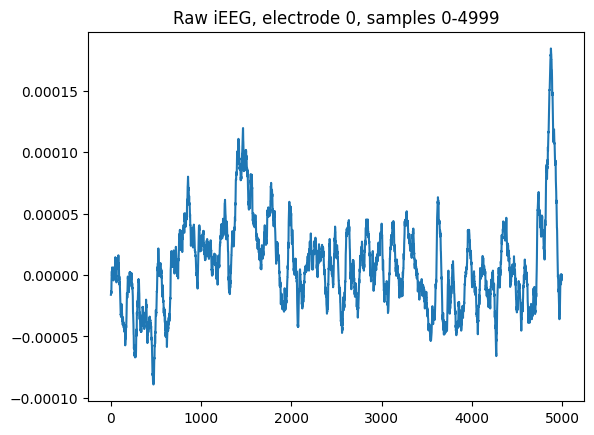

In [9]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Resampling data 

In [10]:
resample_sr = 500
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 276 out of 276 | elapsed:  2.2min finished


<RawEDF | MS026_SWB.edf, 276 x 1630875 (3261.7 s), ~3.35 GB, data loaded>

### Notch filter line noise

In [11]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 276 out of 276 | elapsed:   15.8s finished


<RawEDF | MS026_SWB.edf, 276 x 1630875 (3261.7 s), ~3.35 GB, data loaded>

### Photodiode
- examine photodiode 

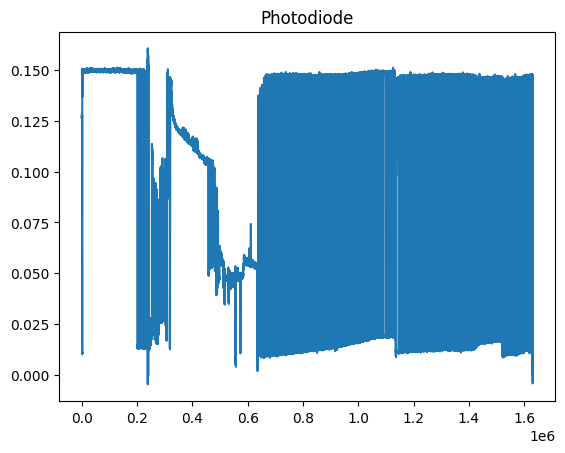

In [12]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [13]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='DC1', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/photodiode.fif
[done]


In [14]:
mne_data.drop_channels(['DC1'])

<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

### Anatomical Localization

In [15]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

In [16]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

label BN246label          x          y          z      mni_x  \
0     LaCaS1    A32sg_L  -2.954574  41.329210   4.799997  -3.150189   
1    LaCaS10   A9/46d_L -14.150090  45.726392  48.399994 -14.612690   
2    LaCaS11      A9l_L -15.349610  46.126136  53.199994 -16.068791   
3    LaCaS12      A9l_L -16.149290  46.126136  57.999994 -17.096981   
4    LaCaS13    Unknown -16.948969  46.126136  63.599993 -18.060868   
..       ...        ...        ...        ...        ...        ...   
163   RmOlF6     A11l_R  33.430855  50.123574   8.399997  36.273305   
164   RmOlF7  A12/47o_R  37.429254  49.723831  10.399996  40.477926   
165   RmOlF8  A12/47l_R  42.227333  49.723831  12.399996  45.600992   
166   RmOlF9     A45r_R  46.625571  49.723831  14.799996  50.223671   
167   uRmOlF      A13_R   7.441263  48.524599  -4.000003   8.405835   

         mni_y      mni_z       gm  \
0    27.626674 -11.313929     Gray   
1    45.647438  30.886915    White   
2    47.523347  35.735259     Gray   
3    48.985539  40.715012     Gray   
4    50.562598  46.419275  Unknown   
..         ...        ...      ...   
163  37.087206 -11.909190     Gray   
164  37.432671  -9.831393     Gray   
165  38.133258  -7.732312     Gray   
166  38.960073  -5.163690     Gray   
167  31.034159 -22.937916     Gray   

                                                   NMM      Anat  \
0                   Left ACgG anterior cingulate gyrus  Area s24   
1                           Left Cerebral White Matter   Unknown   
2                      Left SFG superior frontal gyrus   Unknown   
3                      Left SFG superior frontal gyrus   Unknown   
4                                              Unknown   Unknown   
..                                                 ...       ...   
163                   Right LOrG lateral orbital gyrus   Unknown   
164                        Right Cerebral White Matter   Unknown   
165  Right OrIFG orbital part of the inferior front...   Unknown   
166  Right TrIFG triangular part of the inferior fr...   Unknown   
167                             Right GRe gyrus rectus  Area Fo1   

                    AnatMacro    BN246                               YBA_1  \
0         L Mid Orbital Gyrus     L CG              Left cingulate gyrus C   
1    L Superior Frontal Gyrus    L MFG                             Unknown   
2    L Superior Frontal Gyrus    L SFG     Left superior frontal gyrus 2 D   
3    L Superior Frontal Gyrus    L SFG     Left superior frontal gyrus 2 D   
4    L Superior Frontal Gyrus  Unknown     Left superior frontal gyrus 2 D   
..                        ...      ...                                 ...   
163       R IFG (p Orbitalis)    R OrG              Right pars orbitalis B   
164       R IFG (p Orbitalis)    R OrG              Right pars orbitalis B   
165       R IFG (p Orbitalis)    R OrG  Right anterior pars triangularis A   
166       R IFG (p Orbitalis)    R IFG  Right anterior pars triangularis A   
167            R Rectal Gyrus    R OrG           Right frontal orbital 4 A   

    ManualExamination  Notes  
0                 NaN    NaN  
1                  WM    NaN  
2                  WM    NaN  
3                 OOB    NaN  
4                 OOB    NaN  
..                ...    ...  
163                WM    NaN  
164               NaN    NaN  
165               NaN    NaN  
166               NaN    NaN  
167               NaN    NaN  

[168 rows x 16 columns]

In [17]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS13',
 'LaCaS14',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMsP1',
 'LCMsP10',
 'LCMsP11',
 'LCMsP12',
 'LCMsP13',
 'LCMsP14',
 'LCMsP2',
 'LCMsP3',
 'LCMsP4',
 'LCMsP5',
 'LCMsP6',
 'LCMsP7',
 'LCMsP8',
 'LCMsP9',
 'LHplT1',
 'LHplT10',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'uLHplT',
 'LHtOc1',
 'LHtOc10',
 'LHtOc11',
 'LHtOc12',
 'LHtOc13',
 'LHtOc14',
 'LHtOc15',
 'LHtOc16',
 'LHtOc2',
 'LHtOc3',
 'LHtOc4',
 'LHtOc5',
 'LHtOc6',
 'LHtOc7',
 'LHtOc8',
 'LHtOc9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'uLmOlF',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13'

In [18]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c33', 'c34', 'rcmsp15', 'rcmsp16', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'abs1', 'abs2', 'chest1', 'chest2', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc15', 'dc16', 'trig', 'osat', 'pr', 'pleth']


In [19]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is greater than the number of electrodes in the localization file


In [20]:
unmatched_seeg #make sure there are no unmatched names


[]

In [21]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [22]:
new_name_dict #make sure this passes the eye test 


{'lmolf1': 'lmolf1',
 'lmolf2': 'lmolf2',
 'lmolf3': 'lmolf3',
 'lmolf4': 'lmolf4',
 'lmolf5': 'lmolf5',
 'lmolf6': 'lmolf6',
 'lmolf7': 'lmolf7',
 'lmolf8': 'lmolf8',
 'lmolf9': 'lmolf9',
 'rmolf1': 'rmolf1',
 'rmolf2': 'rmolf2',
 'rmolf3': 'rmolf3',
 'rmolf4': 'rmolf4',
 'rmolf5': 'rmolf5',
 'rmolf6': 'rmolf6',
 'rmolf7': 'rmolf7',
 'rmolf8': 'rmolf8',
 'rmolf9': 'rmolf9',
 'lcmsp1': 'lcmsp1',
 'lcmsp2': 'lcmsp2',
 'lcmsp3': 'lcmsp3',
 'lcmsp4': 'lcmsp4',
 'lcmsp5': 'lcmsp5',
 'lcmsp6': 'lcmsp6',
 'lcmsp7': 'lcmsp7',
 'lcmsp8': 'lcmsp8',
 'lcmsp9': 'lcmsp9',
 'lcmsp10': 'lcmsp10',
 'lcmsp11': 'lcmsp11',
 'lcmsp12': 'lcmsp12',
 'lcmsp13': 'lcmsp13',
 'lcmsp14': 'lcmsp14',
 'c33': 'c33',
 'c34': 'c34',
 'rcmsp1': 'rcmsp1',
 'rcmsp2': 'rcmsp2',
 'rcmsp3': 'rcmsp3',
 'rcmsp4': 'rcmsp4',
 'rcmsp5': 'rcmsp5',
 'rcmsp6': 'rcmsp6',
 'rcmsp7': 'rcmsp7',
 'rcmsp8': 'rcmsp8',
 'rcmsp9': 'rcmsp9',
 'rcmsp10': 'rcmsp10',
 'rcmsp11': 'rcmsp11',
 'rcmsp12': 'rcmsp12',
 'rcmsp13': 'rcmsp13',
 'rcmsp

In [23]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

In [24]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 82 left sEEG and 84 right sEEG electrodes
We have a total of 166 sEEG electrodes


In [25]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawEDF | MS026_SWB.edf, 275 x 1630875 (3261.7 s), ~3.34 GB, data loaded>

In [26]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawEDF | MS026_SWB.edf, 166 x 1630875 (3261.7 s), ~2.02 GB, data loaded>

In [27]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS026_SWB.edf, 166 x 1630875 (3261.7 s), ~2.02 GB, data loaded>

In [28]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [29]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [30]:
probe_ch_counts

{'lacas': 14,
 'laglt': 9,
 'lcmsp': 14,
 'lhplt': 10,
 'lhtoc': 16,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'raglt': 9,
 'rcmsp': 14,
 'rhplt': 10,
 'rhtoc': 16,
 'rmcms': 10,
 'rmolf': 9,
 'ulhplt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

## ~DEPRECIATED - Signal Cleaning Before Re-Ref~

~- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary~ \
~- This process is iterative depending on how TFRs look.~

In [33]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
# lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) # good for this patient

In [34]:
#  %matplotlib notebook
# fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/20)


In [35]:
# mne_data.info['bads'] = ['lacas11',
#  'laglt5',
#  'rhplt9',
#  'raglt9',
#  'lhplt1',
#  'lhplt2',
#  'rcmsp16',
#  'rhplt3',
#  'raglt4',
#  'rcmsp2',
#  'lcmsp13',
#  'rcmsp6']

## Save mne_data
NO CHANNEL REMOVAL BEFORE RE-REFERENCING \
**PIPELINE CHANGE IMPLEMENTED 05/09/2024**

In [31]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg.fif
[done]


# Re-referencing + Signal Cleaning
1. bipolar rereference raw ieeg data 
2. plot lfp + psd for bp data
3. remove bad bp reref channels
4. localize roi for reref channels
5. save bp reref data & localization info


In [32]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/raw_ieeg.fif...
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Reading 0 ... 1630874  =      0.000 ...  3261.748 secs...


### Bipolar Re-ref

In [33]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=75, n_times=1630875
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas5-lacas6, lacas6-lacas7, lacas7-lacas8, lacas8-lacas9, laglt1-laglt2, laglt4-laglt5, laglt5-laglt6, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, lcmsp1-lcmsp2, lcmsp2-lcmsp3, lcmsp3-lcmsp4, lcmsp4-lcmsp5, lcmsp5-lcmsp6, lcmsp6-lcmsp7, lcmsp7-lcmsp8, lcmsp11-lcmsp12, lcmsp12-lcmsp13, lcmsp13-lcmsp14, lhplt7-lhplt8, lhtoc10-lhtoc11, lhtoc11-lhtoc12, lhtoc13-lhtoc14, lhtoc14-lhtoc15, lmcms2-lmcms3, lmcms3-lmcms4, lmolf1-lmolf2, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmolf8-lmolf9, racas5-racas6, racas6-racas7, racas7-racas8, racas10-racas11, raglt1-raglt2, raglt2-raglt3, raglt3-raglt4, raglt4-raglt5, raglt6-

In [34]:
mne_data_bp_reref

<Raw | raw_ieeg.fif, 75 x 1630875 (3261.7 s), ~933.3 MB, data loaded>

In [35]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas5-lacas6',
 'lacas6-lacas7',
 'lacas7-lacas8',
 'lacas8-lacas9',
 'laglt1-laglt2',
 'laglt4-laglt5',
 'laglt5-laglt6',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'lcmsp1-lcmsp2',
 'lcmsp2-lcmsp3',
 'lcmsp3-lcmsp4',
 'lcmsp4-lcmsp5',
 'lcmsp5-lcmsp6',
 'lcmsp6-lcmsp7',
 'lcmsp7-lcmsp8',
 'lcmsp11-lcmsp12',
 'lcmsp12-lcmsp13',
 'lcmsp13-lcmsp14',
 'lhplt7-lhplt8',
 'lhtoc10-lhtoc11',
 'lhtoc11-lhtoc12',
 'lhtoc13-lhtoc14',
 'lhtoc14-lhtoc15',
 'lmcms2-lmcms3',
 'lmcms3-lmcms4',
 'lmolf1-lmolf2',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmolf8-lmolf9',
 'racas5-racas6',
 'racas6-racas7',
 'racas7-racas8',
 'racas10-racas11',
 'raglt1-raglt2',
 'raglt2-raglt3',
 'raglt3-raglt4',
 'raglt4-raglt5',
 'raglt6-raglt7',
 'raglt7-raglt8',
 'raglt8-raglt9',
 'rcmsp1-rcmsp2',
 'rcmsp2-rcmsp3',
 'rcmsp3-rcmsp4',
 'rcmsp9-rcmsp10',
 'rcmsp10-rcmsp11',
 'rcmsp11-rcmsp12',
 'rcmsp12-rcmsp13',
 'rhp

# Manual Signal Cleaning 
Methods:
- Use manual bad channel removal for **bipolar** re referenced data 
- This process is iterative depending on how TFRs look. 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


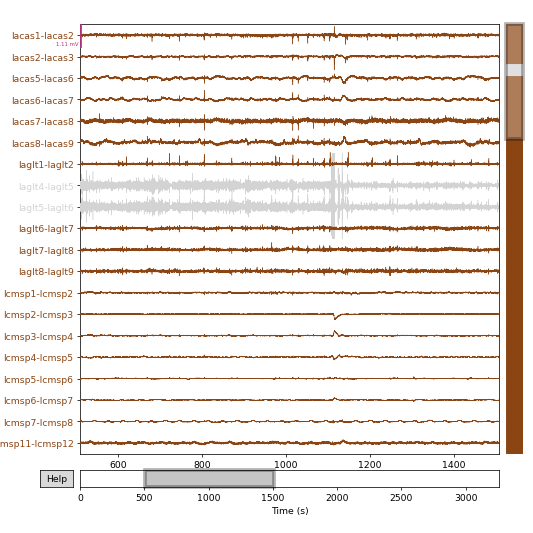

In [39]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=20, scalings=mne_data_bp_reref._data.max()/20)


Effective window size : 0.512 (s)


<IPython.core.display.Javascript object>


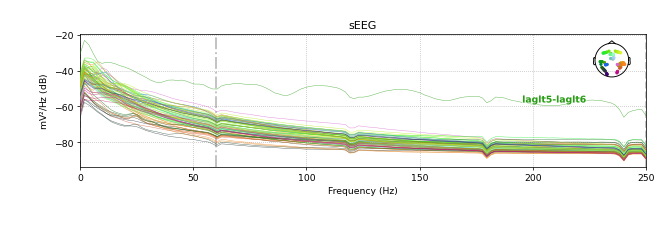

<IPython.core.display.Javascript object>


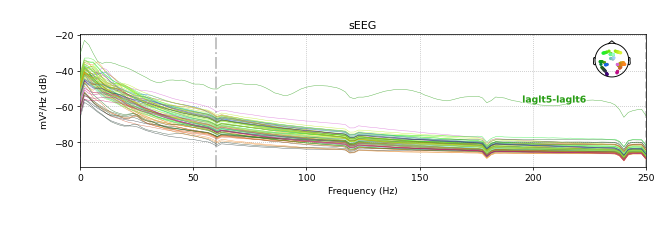

In [38]:
mne_data_bp_reref.compute_psd().plot()

In [42]:
print(mne_data_bp_reref.info['bads'],date)

['laglt4-laglt5', 'laglt5-laglt6'] 05212024


## Save Reref Data

In [43]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif
[done]


In [44]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

# Photodiode Alignment
SWB photodiodes should be aligned to TrialOnset
- extract TrialOnset times to align to photodiode deflection onset 
- clean photodiode data if necessary (if photodiode is inverted, noisy etc)
- align photodiode (if function fails, try manual alignment)
- verify proper alignment by plotting

In [7]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0        1       31.0       mix    64.988546    65.002196      72.045678   
1        2       39.0       mix    78.824276    78.830170      82.056793   
2        3       56.0      gain    89.270097    89.281084      92.684523   
3        4       95.0      gain   109.076507   109.084701     112.124336   
4        5       59.0      gain   119.506867   119.507606     123.534525   
..     ...        ...       ...          ...          ...            ...   
145    146      118.0      loss  2121.553007  2121.553719    2124.359392   
146    147       35.0       mix  2130.636805  2130.644654    2133.887674   
147    148       66.0      gain  2149.412802  2149.420515    2154.527429   
148    149      141.0      loss  2161.873683  2161.881611    2168.286230   
149    150       65.0      gain  2174.941956  2174.942699    2177.181502   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0        72.053316  7.043482      0.0   -1.50  ...      1.50        1.50   
1        82.063629  3.226624      0.0   -0.50  ...     -0.75       -0.75   
2        94.700933  3.403439      0.2    0.00  ...     -0.56       -0.20   
3       114.140568  3.039634      0.6    0.00  ...     -1.49       -0.60   
4       125.551429  4.026918      0.2    0.00  ...      0.84        0.64   
..             ...       ...      ...     ...  ...       ...         ...   
145    2126.374574  2.805673     -0.3   -1.08  ...      1.08        0.30   
146    2133.894733  3.243020      0.0   -0.30  ...     -0.36       -0.36   
147    2156.542478  5.106914      0.3    0.00  ...     -0.84       -0.30   
148    2168.293779  6.404620     -0.6   -1.01  ...      0.41        0.41   
149    2179.196690  2.238803      0.3    0.00  ...     -0.74       -0.30   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0          0.00           0.00        1.50           1.50    -1.50   
1         -0.75          -0.75        0.00           0.00     0.75   
2         -0.56          -0.20        0.00           0.00     0.56   
3         -1.49          -0.60        0.00           0.00     1.49   
4          0.00           0.00        0.84           0.64     0.00   
..          ...            ...         ...            ...      ...   
145        0.00           0.00        1.08           0.30    -1.08   
146       -0.36          -0.36        0.00           0.00     0.36   
147       -0.84          -0.30        0.00           0.00     0.84   
148        0.00           0.00        0.41           0.41    -1.01   
149       -0.74          -0.30        0.00           0.00     0.74   

     decisionCF  pRPE   nRPE  
0         -1.50  0.00  0.000  
1          0.75  0.00  0.000  
2          0.20  0.00 -0.280  
3          0.60  0.00 -0.745  
4          0.20  0.42  0.000  
..          ...   ...    ...  
145       -0.30  0.54  0.000  
146        0.36  0.00  0.000  
147        0.30  0.00 -0.420  
148       -1.01  0.00  0.000  
149        0.30  0.00 -0.370  

[150 rows x 32 columns]

In [8]:
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/photodiode.fif...
Isotrak not found
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Reading 0 ... 1630874  =      0.000 ...  3261.748 secs...


In [9]:
photodiode_data

<Raw | photodiode.fif, 1 x 1630875 (3261.7 s), ~12.4 MB, data loaded>

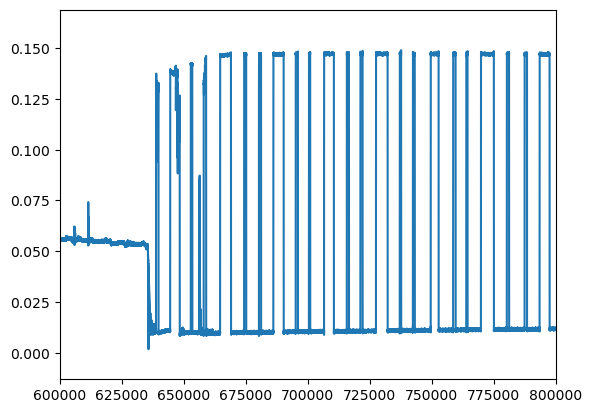

In [10]:
plt.plot(photodiode_data._data[0,:])
plt.xlim([600000,800000])
plt.show()


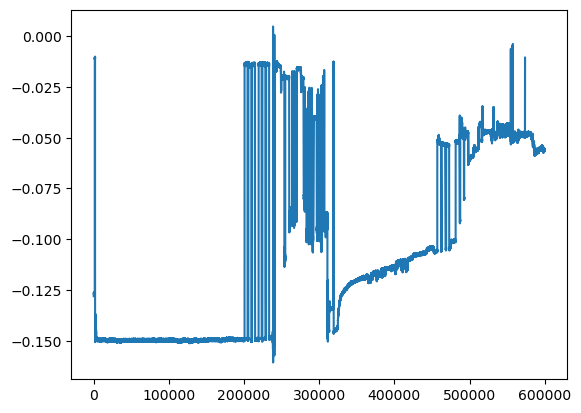

In [11]:
plt.plot(-photodiode_data._data[0, :600000])
# plt.plot(-photodiode_data._data[0, 1000000:1500000])
plt.show()

In [12]:
##### FROM SALMAN

temp_diode = photodiode_data.copy() 
temp_diode._data = -temp_diode._data

temp_diode._data[0, 0:600000] = np.min(temp_diode._data)

In [13]:
np.min(temp_diode._data)

-0.16066963970661163

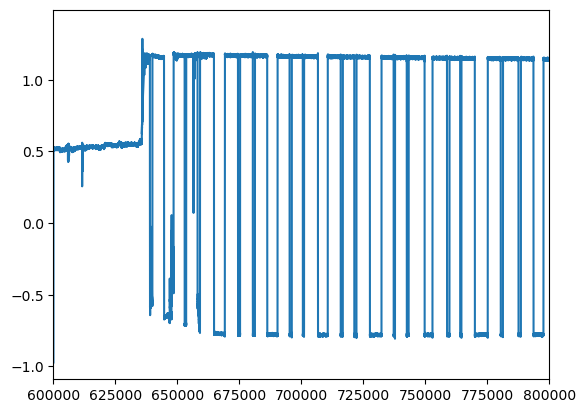

In [14]:
plt.plot(scipy.stats.zscore(temp_diode._data[0, :]))
plt.xlim([600000,800000])
plt.show()

In [15]:
### Photodiode alignment
smoothSize=11
windSize=15

height=0.7

# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

9 blocks
.........

found matches for 120 of 144 pulses
7 blocks
.......

found matches for 100 of 144 pulses


In [16]:
print(slope,offset)

0.9999950674239351 1064.9486062867488


In [17]:
# calculate pulse times from slope + offset
pulses = [(x*slope + offset) for x in beh_ts]
len(pulses) 

150

In [18]:
##### validate by plotting!
photo_sfreq = photodiode_data.info['sfreq']
photo_sfreq


500.0

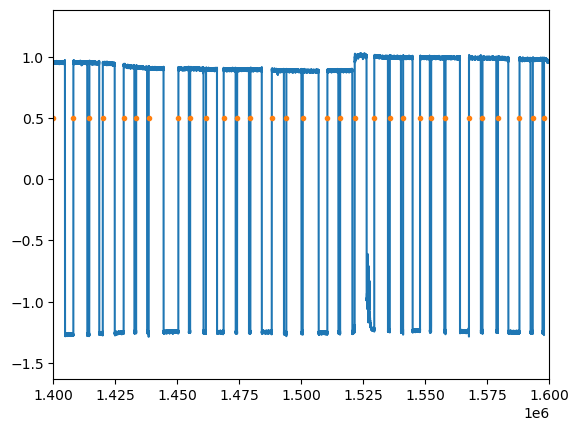

In [19]:
plt.plot(scipy.stats.zscore(-photodiode_data._data[0,:]))
plt.plot(np.array(pulses)*photo_sfreq, 
         np.ones_like(np.array(pulses)*photo_sfreq)-0.5, '.')

plt.xlim([1400000,1600000])
plt.show()


In [20]:
photodiode_params = np.array([slope, offset])
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info'
np.save(diode_info_fname, photodiode_params)


# Epoch Data
- Epoch neural data into trial epochs (and save df with IEDs/artifacts for every ev)
- Save epochs
- Baseline + decompose data into TFRs
- Add behavioral data to epochs metadata
- Plot + save TFRs (examine quality)

Note: Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated


In [21]:
diode_info_fname  = f'{neural_dir}diode_info/{subj_id}_diode_info.npy'
photodiode_params = np.load(diode_info_fname)

photodiode_params

array([9.99995067e-01, 1.06494861e+03])

In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

### Get behavior ts for epochs of interest
- time points in SWB code are nonsensical - choice onset is a repeat of trial onset, and the difference between choice onset and decision onset is just the RT.
- even worse, feedback onset does not accurately mark feedback for safe choice trials - the feedback time is the safe outcome reveal, NOT counterfactual feedback. There is no true counterfactual feedback timestamp that's accurate for every trial. 
- Solution - make a new timestamp vector that is +2 seconds after DecisionOnset to use for counterfactual outcome feedback epochs


MAJOR UPDATE 05/09/2024 FROM PIPELINE UPDATE

In [63]:
#### load behavior data and define baseline/analysis epoch timepoints 

#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
behav_df

Round  Trial Num TrialType   TrialOnset  ChoiceOnset  DecisionOnset  \
0        1       31.0       mix    64.988546    65.002196      72.045678   
1        2       39.0       mix    78.824276    78.830170      82.056793   
2        3       56.0      gain    89.270097    89.281084      92.684523   
3        4       95.0      gain   109.076507   109.084701     112.124336   
4        5       59.0      gain   119.506867   119.507606     123.534525   
..     ...        ...       ...          ...          ...            ...   
145    146      118.0      loss  2121.553007  2121.553719    2124.359392   
146    147       35.0       mix  2130.636805  2130.644654    2133.887674   
147    148       66.0      gain  2149.412802  2149.420515    2154.527429   
148    149      141.0      loss  2161.873683  2161.881611    2168.286230   
149    150       65.0      gain  2174.941956  2174.942699    2177.181502   

     FeedbackOnset        RT  SafeBet  LowBet  ...  totalCPE decisionCPE  \
0        72.053316  7.043482      0.0   -1.50  ...      1.50        1.50   
1        82.063629  3.226624      0.0   -0.50  ...     -0.75       -0.75   
2        94.700933  3.403439      0.2    0.00  ...     -0.56       -0.20   
3       114.140568  3.039634      0.6    0.00  ...     -1.49       -0.60   
4       125.551429  4.026918      0.2    0.00  ...      0.84        0.64   
..             ...       ...      ...     ...  ...       ...         ...   
145    2126.374574  2.805673     -0.3   -1.08  ...      1.08        0.30   
146    2133.894733  3.243020      0.0   -0.30  ...     -0.36       -0.36   
147    2156.542478  5.106914      0.3    0.00  ...     -0.84       -0.30   
148    2168.293779  6.404620     -0.6   -1.01  ...      0.41        0.41   
149    2179.196690  2.238803      0.3    0.00  ...     -0.74       -0.30   

    totalRegret decisionRegret totalRelief decisionRelief  totalCF  \
0          0.00           0.00        1.50           1.50    -1.50   
1         -0.75          -0.75        0.00           0.00     0.75   
2         -0.56          -0.20        0.00           0.00     0.56   
3         -1.49          -0.60        0.00           0.00     1.49   
4          0.00           0.00        0.84           0.64     0.00   
..          ...            ...         ...            ...      ...   
145        0.00           0.00        1.08           0.30    -1.08   
146       -0.36          -0.36        0.00           0.00     0.36   
147       -0.84          -0.30        0.00           0.00     0.84   
148        0.00           0.00        0.41           0.41    -1.01   
149       -0.74          -0.30        0.00           0.00     0.74   

     decisionCF  pRPE   nRPE  
0         -1.50  0.00  0.000  
1          0.75  0.00  0.000  
2          0.20  0.00 -0.280  
3          0.60  0.00 -0.745  
4          0.20  0.42  0.000  
..          ...   ...    ...  
145       -0.30  0.54  0.000  
146        0.36  0.00  0.000  
147        0.30  0.00 -0.420  
148       -1.01  0.00  0.000  
149        0.30  0.00 -0.370  

[150 rows x 32 columns]

In [64]:
list(zip(behav_df.GambleChoice,behav_df.DecisionOnset,behav_df.FeedbackOnset))

[('safe', 72.04567829996813, 72.05331589991692),
 ('safe', 82.05679339997005, 82.06362869997974),
 ('gamble', 92.68452319991776, 94.70093269995414),
 ('gamble', 112.12433569994757, 114.14056769991294),
 ('gamble', 123.53452479990663, 125.55142889998388),
 ('gamble', 135.2118402000051, 137.22731489990838),
 ('safe', 154.38470499997493, 154.3938366000075),
 ('gamble', 165.97868850000668, 167.99526080000214),
 ('gamble', 176.57306239998434, 178.5894144999329),
 ('gamble', 196.0627866999712, 198.0802107999334),
 ('gamble', 207.30729419994168, 209.32321689999665),
 ('safe', 218.68413609999692, 218.6919373999117),
 ('safe', 235.2759333999129, 235.28353060001973),
 ('gamble', 245.7202546999324, 247.73551329993643),
 ('safe', 258.9299896999728, 258.9375389999477),
 ('safe', 278.3031379999593, 278.31076899997424),
 ('gamble', 290.27954849996604, 292.2959910999052),
 ('gamble', 301.89061859995127, 303.9062145999633),
 ('safe', 319.89773520000745, 319.9054249000037),
 ('safe', 330.5587579999119, 

In [65]:
behav_df['CpeOnset'] = behav_df.DecisionOnset + 2.0
behav_df['CpeOnset']

0        74.045678
1        84.056793
2        94.684523
3       114.124336
4       125.534525
          ...     
145    2126.359392
146    2135.887674
147    2156.527429
148    2170.286230
149    2179.181502
Name: CpeOnset, Length: 150, dtype: float64

## SWB Epochs:

**Baseline epoch** = 1 sec prior to trial onset \
**Decision epoch** = 0.5 sec prior to decision onset (choice epoch) \
**Feedback epoch** = 3 sec after CPE reveal \

*Outputs: Raw epoched data & IED + artifact dfs for every epoch*


In [66]:
# Define epochs of interest according to timestamps from behavior df 

# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [67]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [68]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [69]:
### make epochs should now find IEDs, artifact times, and save info as df in load_path directory for every ev

for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                                                 slope=slope, offset=offset,
                                                 behav_name=event, behav_times=behav_df[event].values,
                                                 ev_start_s=evs[event][0], ev_end_s=evs[event][1],
                                                 buf_s = 1, IED_args=IED_args,
                                                 downsamp_factor=None,  
                                                 detrend=0) #### new - constant detrend by DC offset https://mne.tools/stable/generated/mne.Epochs.html

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif...
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Reading 0 ... 1630874  =      0.000 ...  3261.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    6.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    7.7s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif...
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Reading 0 ... 1630874  =      0.000 ...  3261.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    8.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   12.3s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1251 original time points ...
0 bad epochs dropped
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS026/bp_ref_ieeg.fif...
    Range : 0 ... 1630874 =      0.000 ...  3261.748 secs
Ready.
Reading 0 ... 1630874  =      0.000 ...  3261.748 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:    8.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:   12.9s finished


Used Annotations descriptions: ['CpeOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 2501 original time points ...
0 bad epochs dropped


In [70]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~129.0 MB, data loaded,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~107.5 MB, data loaded,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~214.8 MB, data loaded,
  'CpeOnset': 150>}

In [71]:
# to plot epochs if desired 
# %matplotlib notebook
# fig = epochs_all_subjs_all_evs['MS007']['feedback_start'].plot(n_epochs=10, n_channels=10)

# # Need this following line to save the annotations to the epochs object 
# fig.fake_keypress('a')

### Add behavioral data to metadata

In [72]:
behav_params = ['Round','RT','CpeOnset','GambleChoice','TrialType',
                'SafeBet', 'LowBet', 'HighBet', 'GambleEV','Outcome',
                'Profit', 'TotalProfit', 'CR', 'choiceEV', 'RPE',
                'decisionCPE', 'decisionRegret','decisionRelief', 'decisionCF']

In [73]:
for event in evs.keys():

    event_metadata = pd.DataFrame(columns=behav_params)
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Adding metadata with 19 columns
Adding metadata with 19 columns
Adding metadata with 19 columns


### Save raw epoched data 

In [74]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/{event}_epochs.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.
Overwriting existing file.


In [75]:
epochs_all_evs

{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~129.0 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1.5 - 1 sec, baseline off, ~107.5 MB, data loaded, with metadata,
  'DecisionOnset': 150>,
 'CpeOnset': <Epochs |  150 events (all good), -1 - 4 sec, baseline off, ~214.8 MB, data loaded, with metadata,
  'CpeOnset': 150>}

# Compute Baseline + Analysis TFRs
*Major updates 05/09/2024*
- Instead of removing entire epochs with IEDs, removing +/-100ms of IED or artifact timepoint 
- Now we have two analysis evs of interest - pre-decision epoch and cpe outcome epoch

In [76]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

baseline_ev  = 'TrialOnset' # fixation cross baseline epoch
analysis_evs = ['DecisionOnset','CpeOnset']

# dictionary of event ids and times - repeated from above
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [-0.5, 0], # 0.5 sec prior to choice
       'CpeOnset': [0,3.0] } # 3 sec following CPE outcome reveal - timestamps are made manually above

In [77]:
# Define spectrogram parameters for morlet wavelets 

freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


### Make Baseline TFR Epochs 

In [78]:
#### COMPUTE BASELINE TFRs 

# baseline epoch dictionary 
epochs_all_baseline = {} 

# baseline event = TrialOnset epochs 
baseline_epochs_reref = epochs_all_evs[baseline_ev]

# dropping bad channels from baseline epochs 
baseline_epochs_reref = baseline_epochs_reref.drop_channels(baseline_epochs_reref.info['bads'])

# compute baseline tfr 
temp_pow  = mne.time_frequency.tfr_morlet(baseline_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                          picks=baseline_epochs_reref.ch_names, # now doesn't include bad ch
                                          use_fft=True, n_jobs=-1, output='power',
                                          return_itc=False, average=False) # returns pow (not ITC) for all epochs

temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1]) # clipping epoch to remove buffer

# Remove bad data by naning out +/-100ms around bad timepoints (IEDs and artifacts)
# THE following will now LOAD in dataframes that indicate IED and artifact time points in your data
IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_IED_df.csv') 
artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{baseline_ev}_artifact_df.csv') 

# iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names):
    # lists of IED/artifact timestamps from dfs for one channel (if any)
    ied_ev_list = IED_df[ch_name].dropna().index.tolist()
    artifact_ev_list = artifact_df[ch_name].dropna().index.tolist()
    
    # iterate through every IED timestamp in channel 
    for ev_ in ied_ev_list: 
        # iterate through values in IED df (literal eval = evaluates string as literal python data structures)
        for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((ied_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after 
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
    
    # iterate through every artifact timestamp in channel 
    for ev_ in artifact_ev_list: 
         # iterate through values in artifact df (literal eval = evaluates string as literal python data structures)
        for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
            # remove 100 ms before 
            ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            # remove 100 ms after
            ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * baseline_epochs_reref.info['sfreq'])]).astype(int)
            temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

epochs_all_baseline[baseline_ev] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   31.1s finished


Adding metadata with 19 columns


In [79]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 73, ~1.23 GB>}

### Compute Baseline-corrected TFRs for Analysis Epochs

In [80]:
#### COMPUTE ANALYSIS EVENT TFRs + BASELINE TO BASELINE TFRs 

# repeat baselining procedure for every event in analysis_evs
# remove +/-100ms around IED/artifact individually for each analysis epoch 
# baseline analysis ev tfrs
# iteratively check for zscores still above 10 std, remove those timepoints, then recompute baselined tfr


power_epochs = {} # keys = analysis evs 

for event in analysis_evs: 
    print('Compute baselined TFR for epoch: ',event)
    
    # extract raw epoch data for analysis ev 
    event_epochs_reref = epochs_all_evs[event].copy()
    # dropping bad channels from baseline epochs 
    event_epochs_reref = event_epochs_reref.drop_channels(event_epochs_reref.info['bads'])
    ch_names = event_epochs_reref.ch_names
    
    # compute TFR from raw epoched data
    temp_pow = mne.time_frequency.tfr_morlet(event_epochs_reref, freqs=freqs, n_cycles=n_cycles, 
                                             picks=event_epochs_reref.ch_names, 
                                             use_fft=True, n_jobs=-1, output='power', 
                                             return_itc=False, average=False)
    # crop 1.0 sec buffer from analysis epoch 
    temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
    
    ### repeat IED/artifact removal procedure used for baseline epochs, but with analysis event IED/artifact times
    
    # load IED/artifact dfs specific to event in analysis evs
    IED_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_IED_df.csv') 
    artifact_df = pd.read_csv(f'{neural_dir}{subj_id}/{event}_artifact_df.csv') 
    
    # iterate through each channel, IED/artifact & nan tfr data +/-100ms from IED/artifact
    for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
        ied_ev_list = IED_df[ch_name].dropna().index.tolist()
        artifact_ev_list = artifact_df[ch_name].dropna().index.tolist() 
        for ev_ in ied_ev_list: 
            for ied_ in literal_eval(IED_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((ied_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((ied_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan
        for ev_ in artifact_ev_list: 
            for artifact_ in literal_eval(artifact_df[ch_name].iloc[ev_]):
                # remove 100 ms before 
                ev_ix_start = np.max([0, np.floor((artifact_- 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                # remove 100 ms after
                ev_ix_end = np.min([temp_pow.data.shape[-1], np.ceil((artifact_ + 0.1) * event_epochs_reref.info['sfreq'])]).astype(int)
                temp_pow.data[ev_, ch_ix, :, ev_ix_start:ev_ix_end] = np.nan

    ##### remove extreme power values (z>10) remaining after IED/artifact removal 
    # iterative process - baseline correct event TFR, remove z > 10, re-baseline until no z>10 or reached max iters
    
                
    # Let's nan out absurd z-scores (10 std above baseline???) that escaped our artifact detection, noise removal, and baselining
    absurdity_threshold = 10 # zscore threshold for removal
    max_iter = 10 # max number of iterations for while loop 
    large_z_flag=True # flag that indicates whether large zs are present, when all z<10 = False in while loop

    iteration = 0 # intialize iter counter
    while (large_z_flag==True) & (iteration<max_iter): # while z>10 still in tfr or under max iter num 
        print(f'baseline z-score iteration # {iteration}')
        # Baseline by all the baseline periods in the session
        baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                              baseline_mne=epochs_all_baseline[baseline_ev].data,  
                              mode='zscore', ev_axis=0, elec_axis=1, freq_axis=2, time_axis=3)

        large_z_mask = np.where(baseline_corrected_power>absurdity_threshold)
        if large_z_mask[0].shape[0] == 0:
            # no more large z
            large_z_flag = False
        else:
            # NaN it out in the event of interest prior to re-running the baseline z-score to prevent
            # contamination of all z's
            temp_pow.data[large_z_mask] = np.nan

        iteration +=1
    
    # input baseline corrected pow into mne EpochsTFR object once all z>10 removed or iteratively removed 10x 
    zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power,
                                        temp_pow.times, freqs)
    
    # add metadata to baseline corrected TFR event epochs object 
    zpow.metadata = event_epochs_reref.metadata
    
    # save data (#conda install -c conda-forge h5io must install to save tfr data)
    zpow.save(f'{neural_dir}{subj_id}/{subj_id}_{event}-tfr.h5', overwrite=True) 
    
    # store event zpow epochs in dict for all analysis evs 
    power_epochs[event] = zpow
    

Compute baselined TFR for epoch:  DecisionOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   27.2s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
Not setting metadata
Adding metadata with 19 columns
Compute baselined TFR for epoch:  CpeOnset


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done  70 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:   57.4s finished


Adding metadata with 19 columns
baseline z-score iteration # 0
baseline z-score iteration # 1
baseline z-score iteration # 2
baseline z-score iteration # 3
baseline z-score iteration # 4
baseline z-score iteration # 5
baseline z-score iteration # 6
baseline z-score iteration # 7
Not setting metadata
Adding metadata with 19 columns


In [81]:
power_epochs

{'DecisionOnset': <EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 73, ~629.2 MB>,
 'CpeOnset': <EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 73, ~3.67 GB>}

In [82]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [-0.500000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 73, ~629.2 MB>

In [83]:
power_epochs['CpeOnset']

<EpochsTFR | time : [0.000000, 3.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 73, ~3.67 GB>

# Plot TFRs 
- For each analysis event, plot the mean TFR across all epochs for all channels
- Save plots
- Visually inspect TFRs to see if further data cleaning is necessary

In [84]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/single_elec_tfrs/{subj_id}/'

# print date of TFR plotting 
date = datetime.date.today().strftime('%m%d%Y')
print(date, offset) # print date, double check current slope/offset


05212024 1064.9486062867488


Plot TFR for epoch:  DecisionOnset


<IPython.core.display.Javascript object>


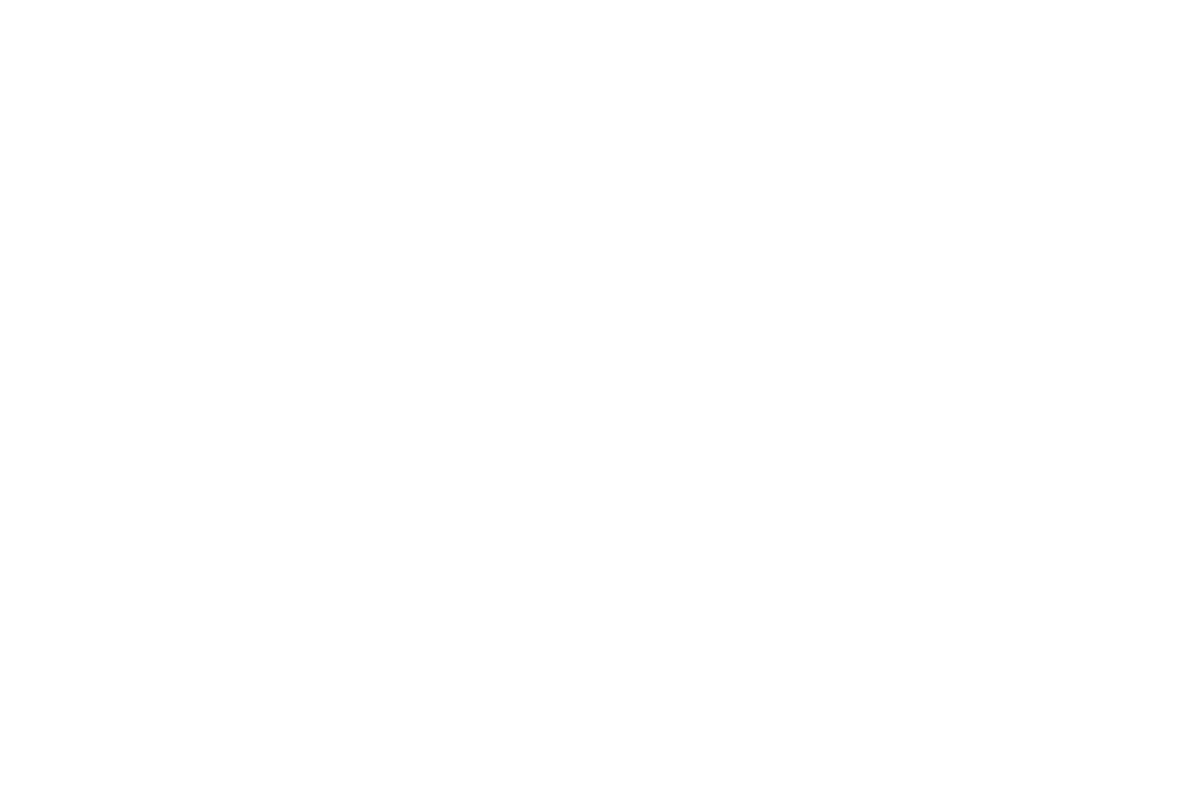

<IPython.core.display.Javascript object>


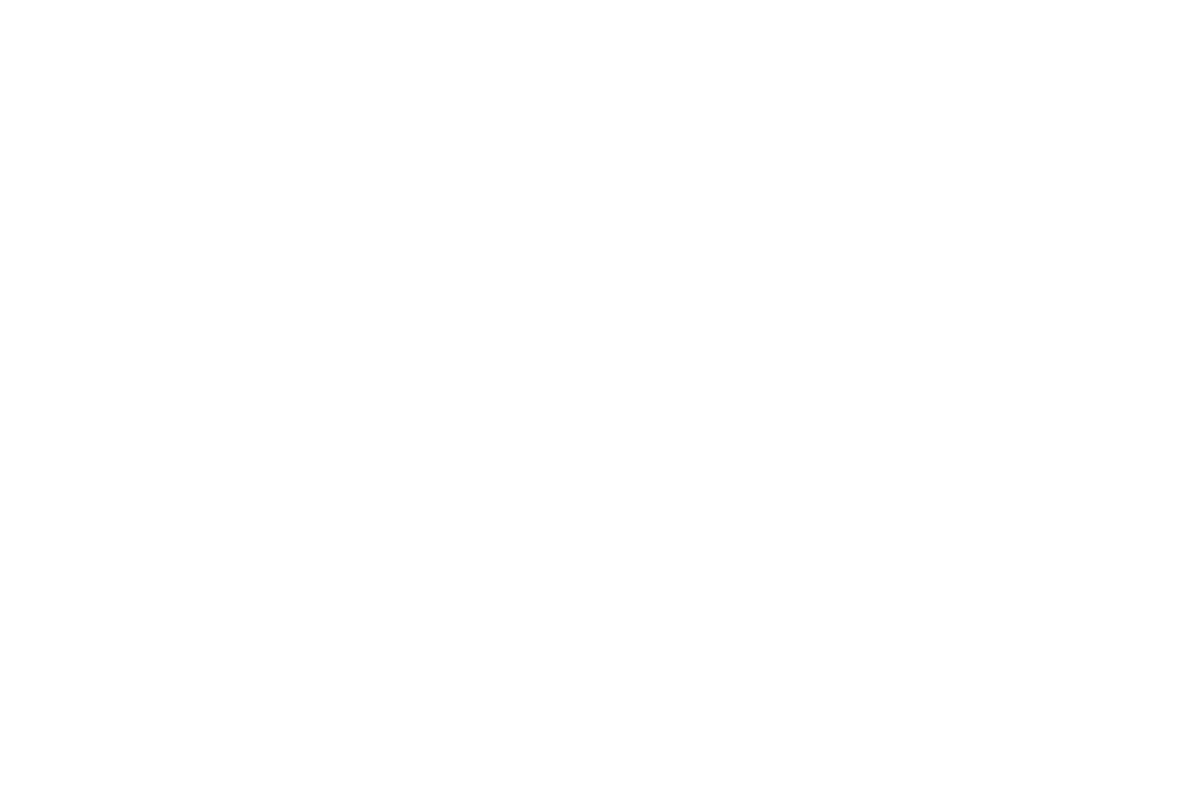

<IPython.core.display.Javascript object>


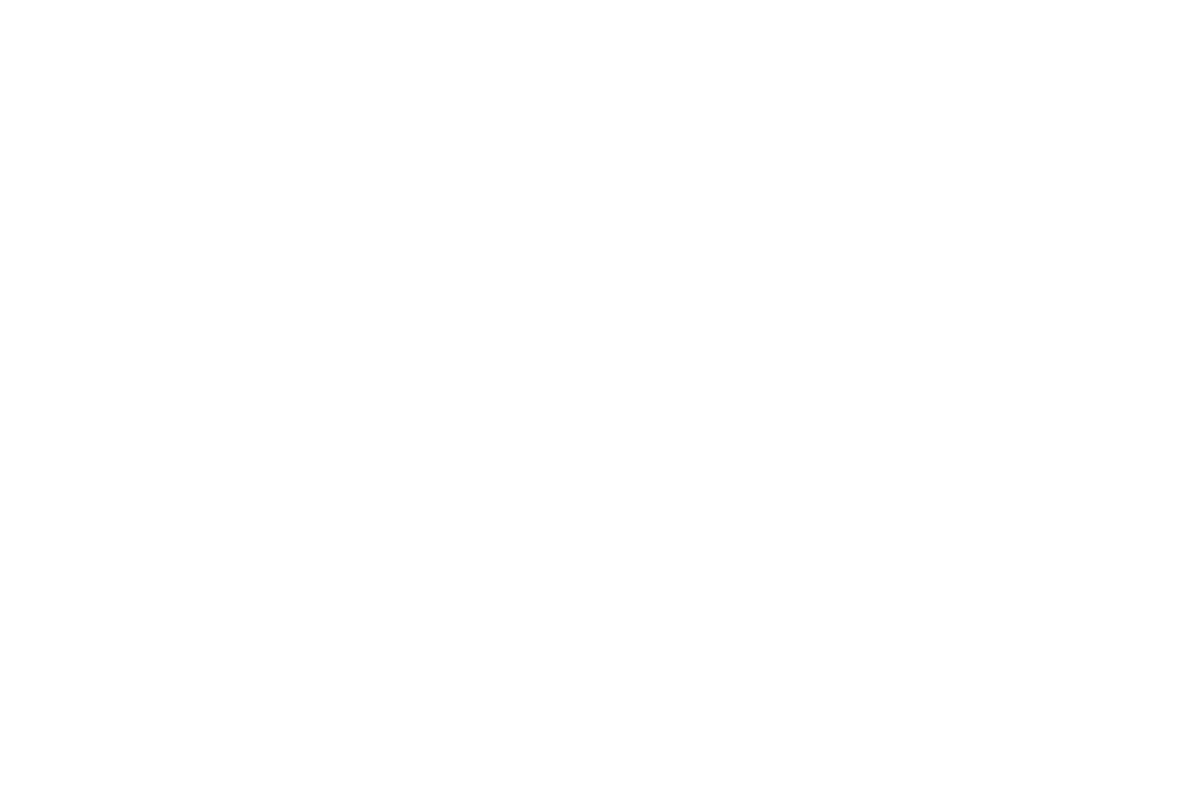

<IPython.core.display.Javascript object>


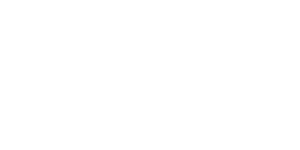

<IPython.core.display.Javascript object>


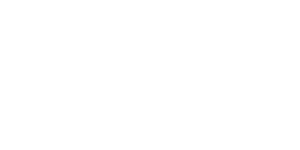

<IPython.core.display.Javascript object>


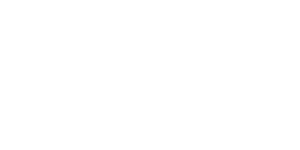

<IPython.core.display.Javascript object>


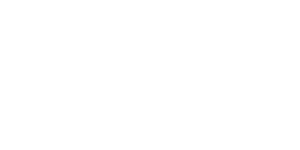

<IPython.core.display.Javascript object>


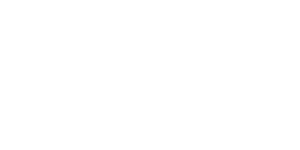

<IPython.core.display.Javascript object>


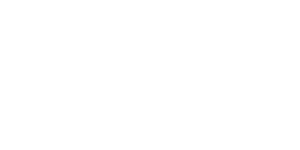

<IPython.core.display.Javascript object>


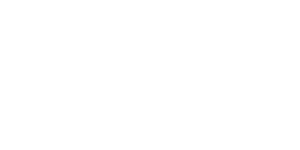

<IPython.core.display.Javascript object>


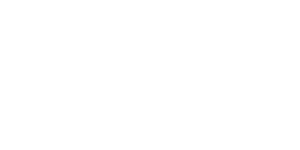

<IPython.core.display.Javascript object>


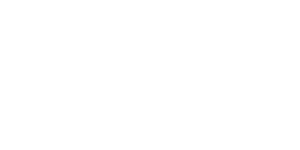

<IPython.core.display.Javascript object>


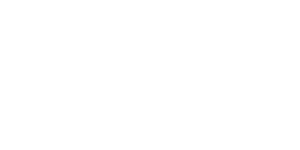

<IPython.core.display.Javascript object>


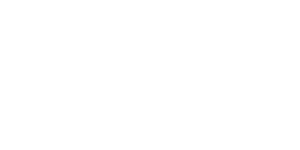

<IPython.core.display.Javascript object>


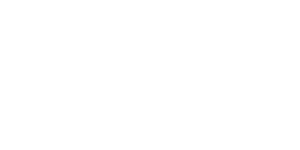

<IPython.core.display.Javascript object>


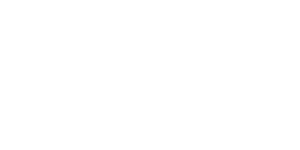

<IPython.core.display.Javascript object>


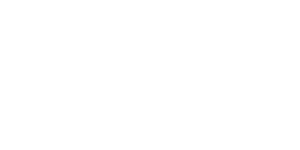

<IPython.core.display.Javascript object>


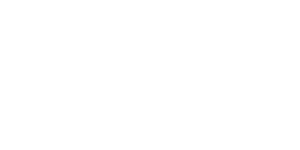

<IPython.core.display.Javascript object>


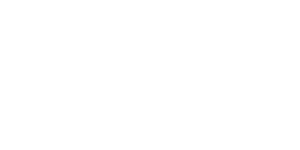

<IPython.core.display.Javascript object>


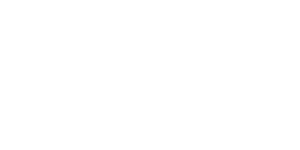

<IPython.core.display.Javascript object>


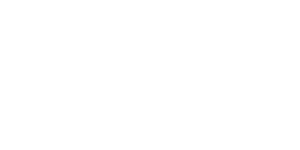

<IPython.core.display.Javascript object>


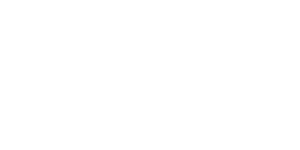

<IPython.core.display.Javascript object>


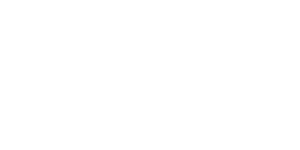

<IPython.core.display.Javascript object>


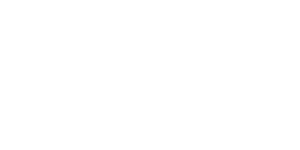

<IPython.core.display.Javascript object>


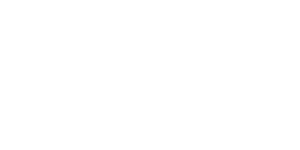

<IPython.core.display.Javascript object>


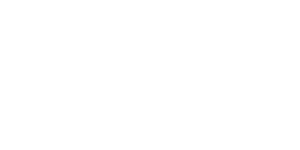

<IPython.core.display.Javascript object>


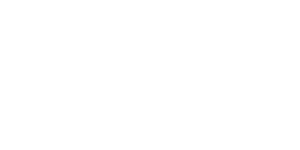

<IPython.core.display.Javascript object>


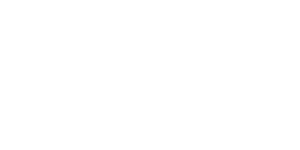

<IPython.core.display.Javascript object>


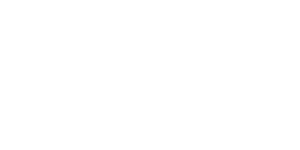

<IPython.core.display.Javascript object>


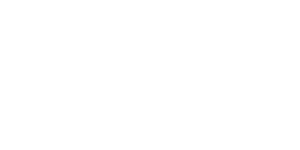

<IPython.core.display.Javascript object>


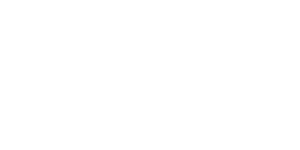

<IPython.core.display.Javascript object>


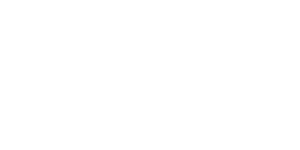

<IPython.core.display.Javascript object>


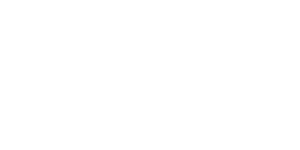

<IPython.core.display.Javascript object>


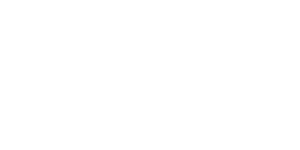

<IPython.core.display.Javascript object>


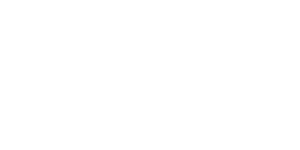

<IPython.core.display.Javascript object>


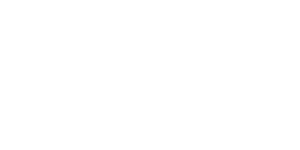

<IPython.core.display.Javascript object>


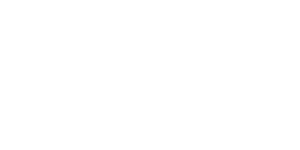

<IPython.core.display.Javascript object>


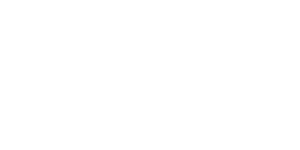

<IPython.core.display.Javascript object>


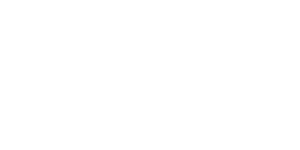

<IPython.core.display.Javascript object>


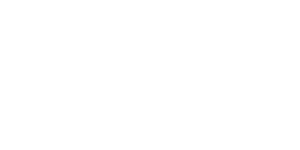

<IPython.core.display.Javascript object>


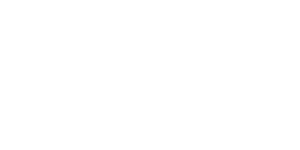

<IPython.core.display.Javascript object>


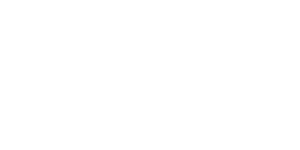

<IPython.core.display.Javascript object>


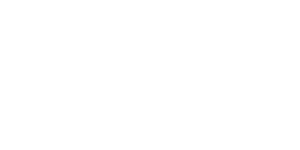

<IPython.core.display.Javascript object>


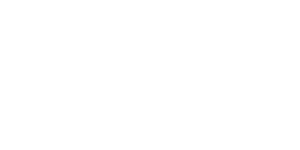

<IPython.core.display.Javascript object>


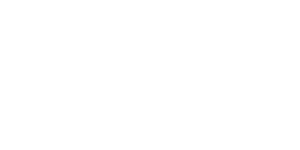

<IPython.core.display.Javascript object>


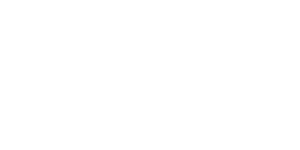

<IPython.core.display.Javascript object>


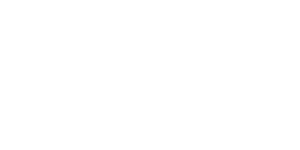

<IPython.core.display.Javascript object>


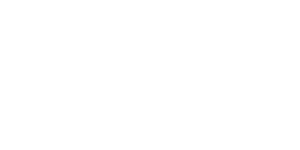

<IPython.core.display.Javascript object>


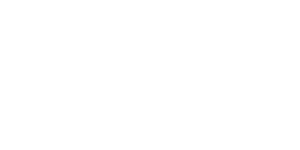

<IPython.core.display.Javascript object>


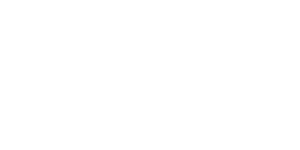

<IPython.core.display.Javascript object>


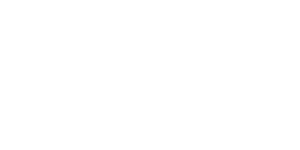

<IPython.core.display.Javascript object>


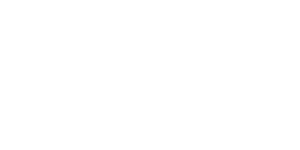

<IPython.core.display.Javascript object>


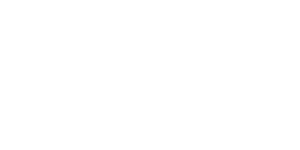

<IPython.core.display.Javascript object>


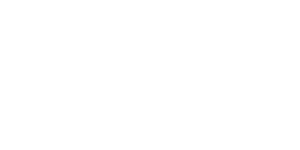

<IPython.core.display.Javascript object>


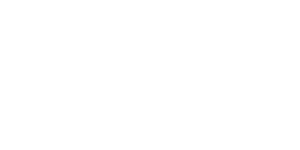

<IPython.core.display.Javascript object>


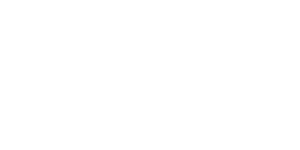

<IPython.core.display.Javascript object>


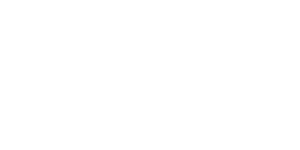

<IPython.core.display.Javascript object>


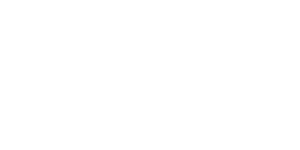

<IPython.core.display.Javascript object>


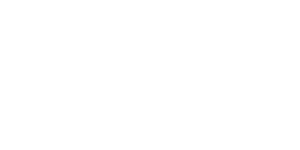

<IPython.core.display.Javascript object>


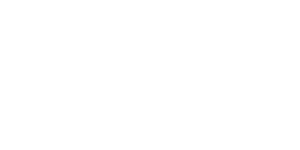

<IPython.core.display.Javascript object>


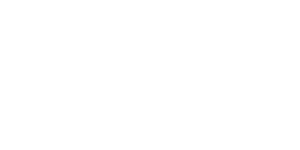

<IPython.core.display.Javascript object>


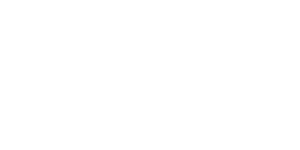

<IPython.core.display.Javascript object>


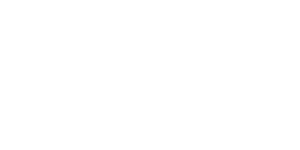

<IPython.core.display.Javascript object>


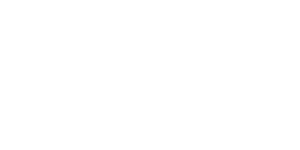

<IPython.core.display.Javascript object>


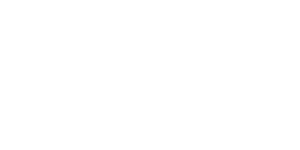

<IPython.core.display.Javascript object>


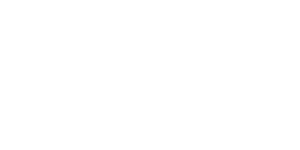

<IPython.core.display.Javascript object>


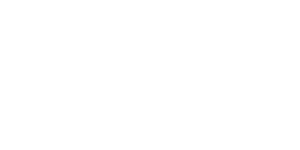

<IPython.core.display.Javascript object>


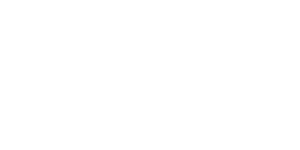

<IPython.core.display.Javascript object>


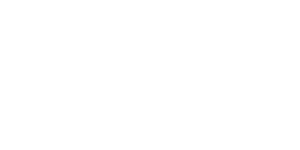

<IPython.core.display.Javascript object>


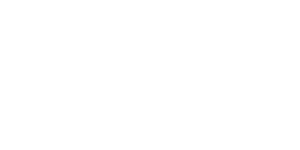

<IPython.core.display.Javascript object>


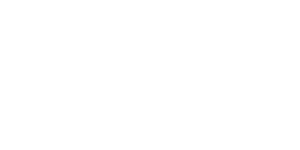

<IPython.core.display.Javascript object>


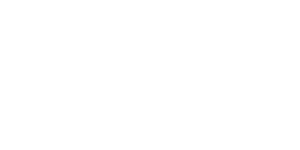

<IPython.core.display.Javascript object>


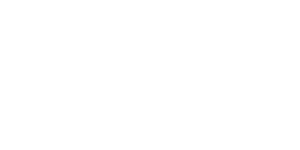

Plot TFR for epoch:  CpeOnset


<IPython.core.display.Javascript object>


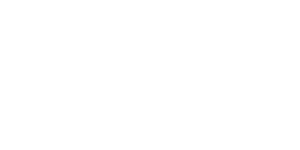

<IPython.core.display.Javascript object>


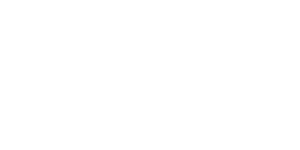

<IPython.core.display.Javascript object>


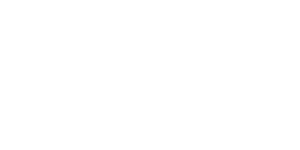

<IPython.core.display.Javascript object>


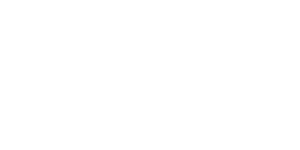

<IPython.core.display.Javascript object>


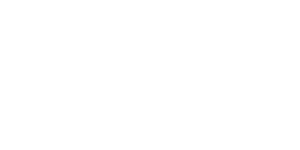

<IPython.core.display.Javascript object>


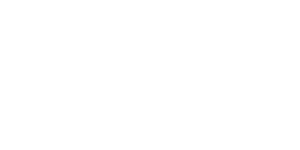

<IPython.core.display.Javascript object>


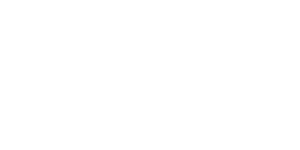

<IPython.core.display.Javascript object>


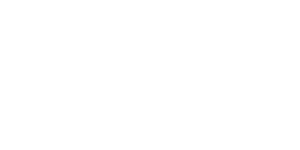

<IPython.core.display.Javascript object>


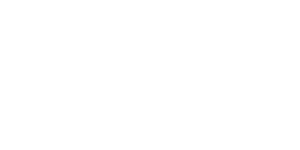

<IPython.core.display.Javascript object>


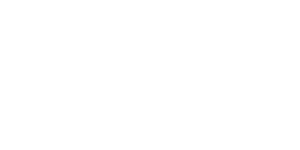

<IPython.core.display.Javascript object>


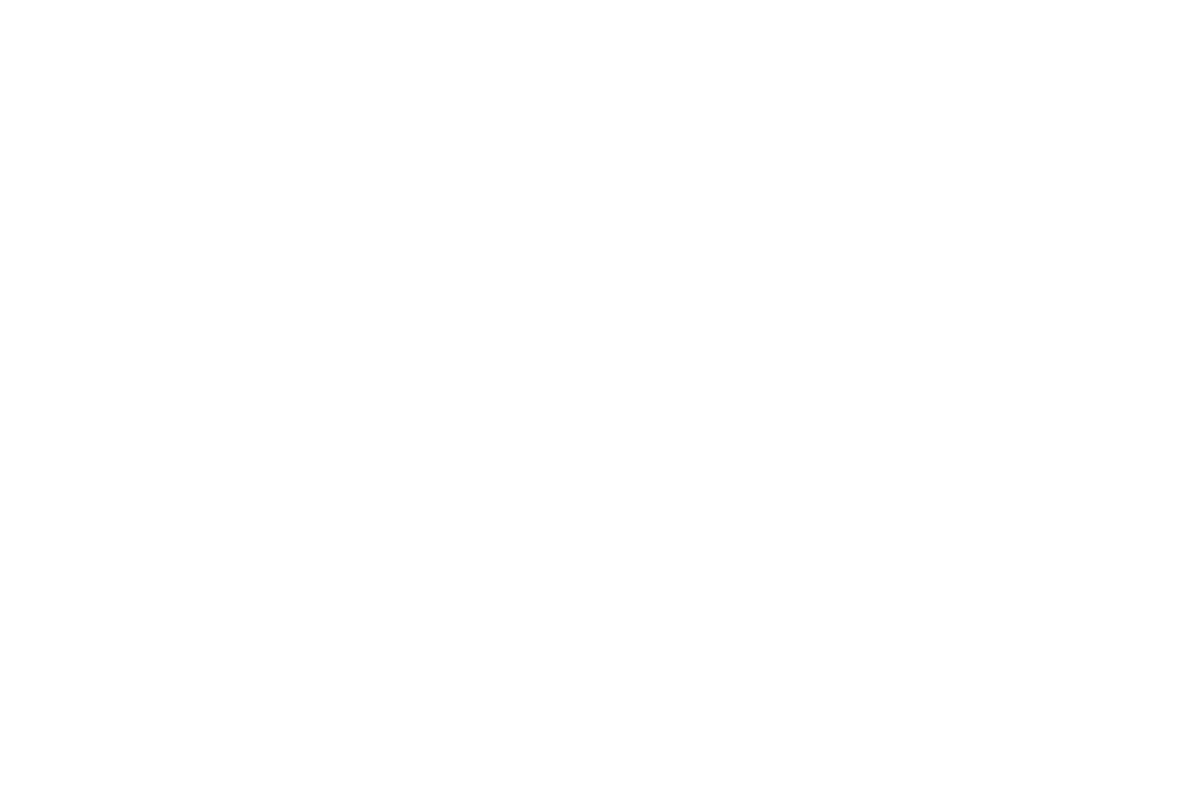

<IPython.core.display.Javascript object>


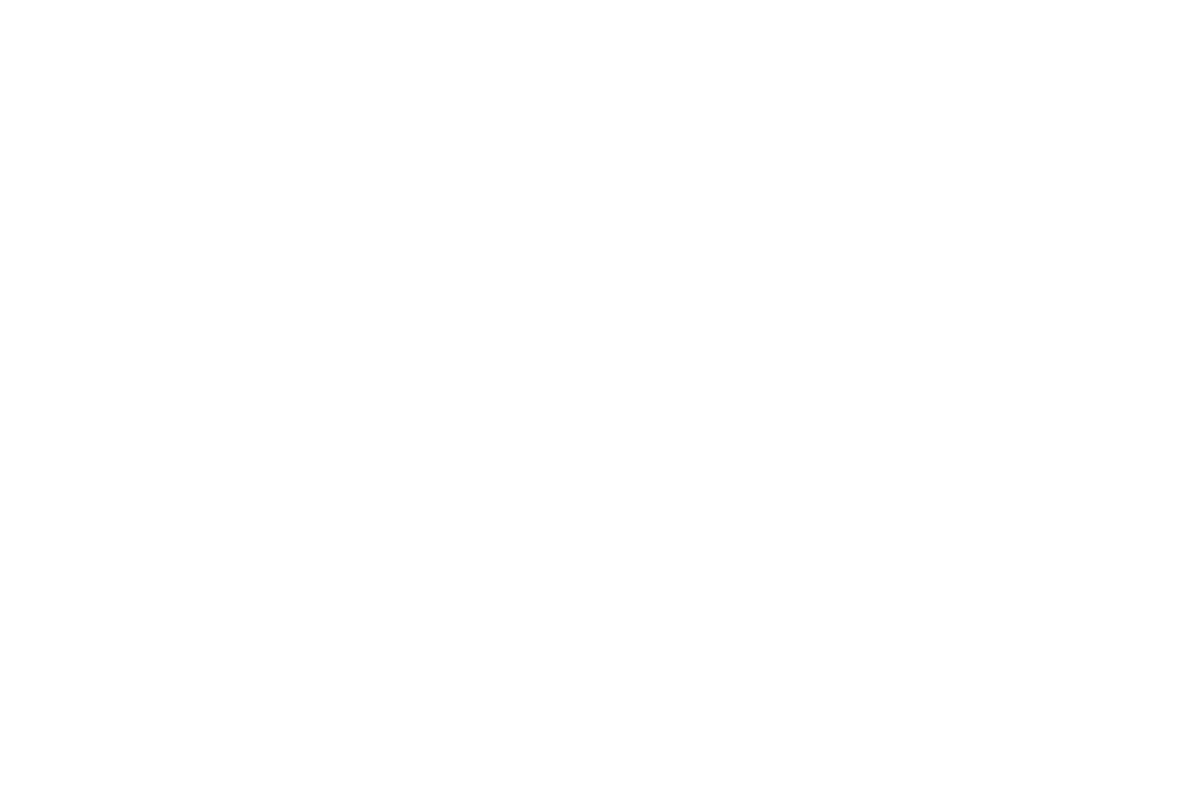

<IPython.core.display.Javascript object>


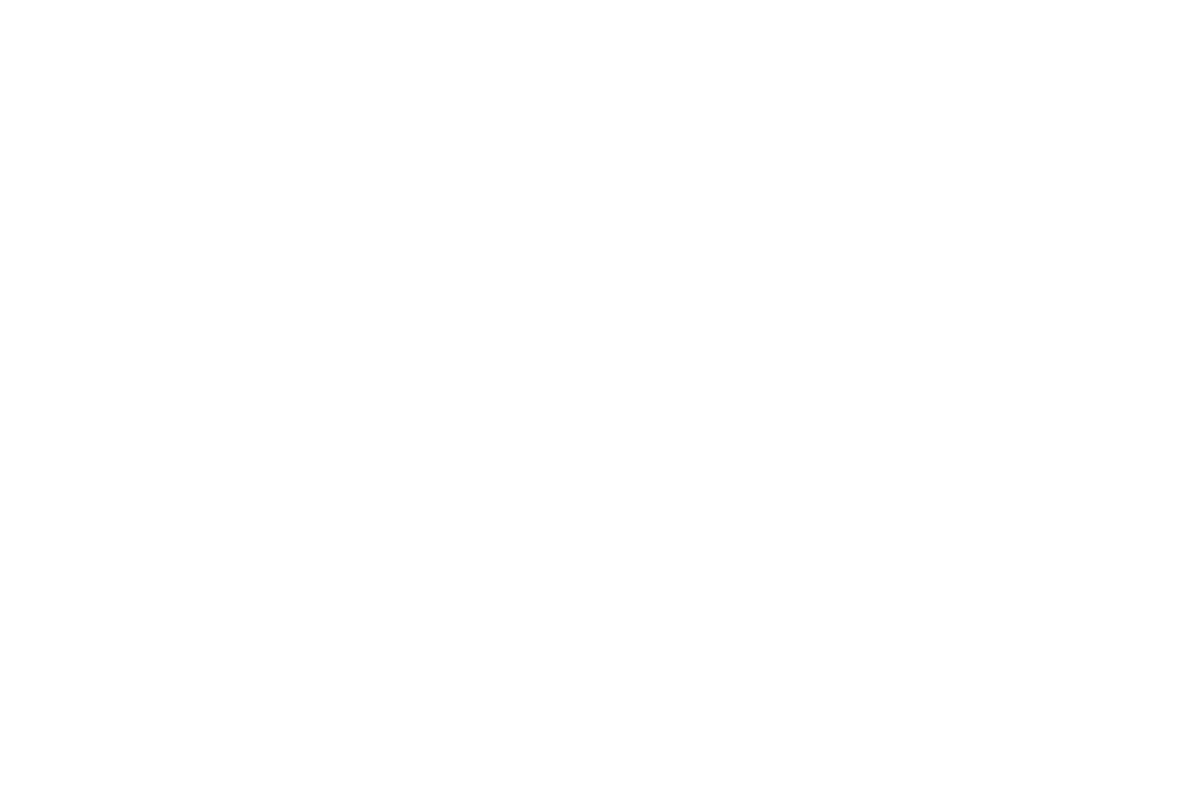

<IPython.core.display.Javascript object>


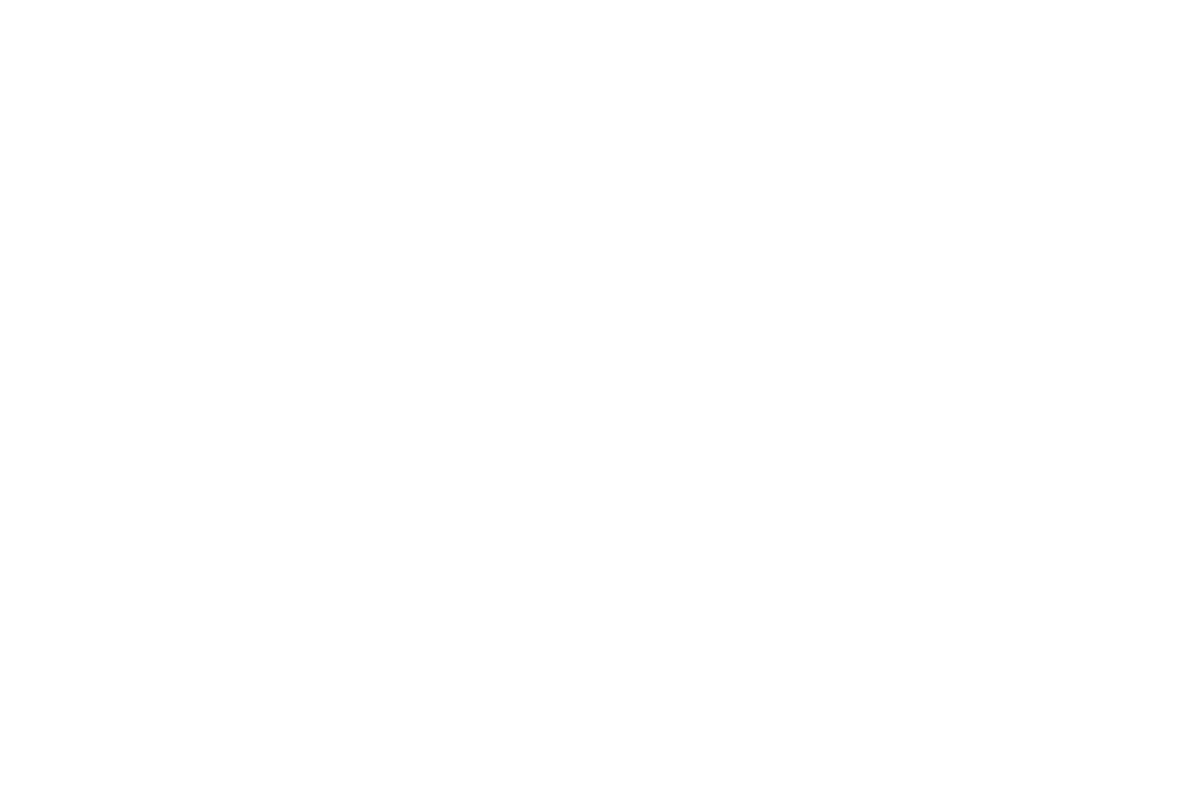

<IPython.core.display.Javascript object>


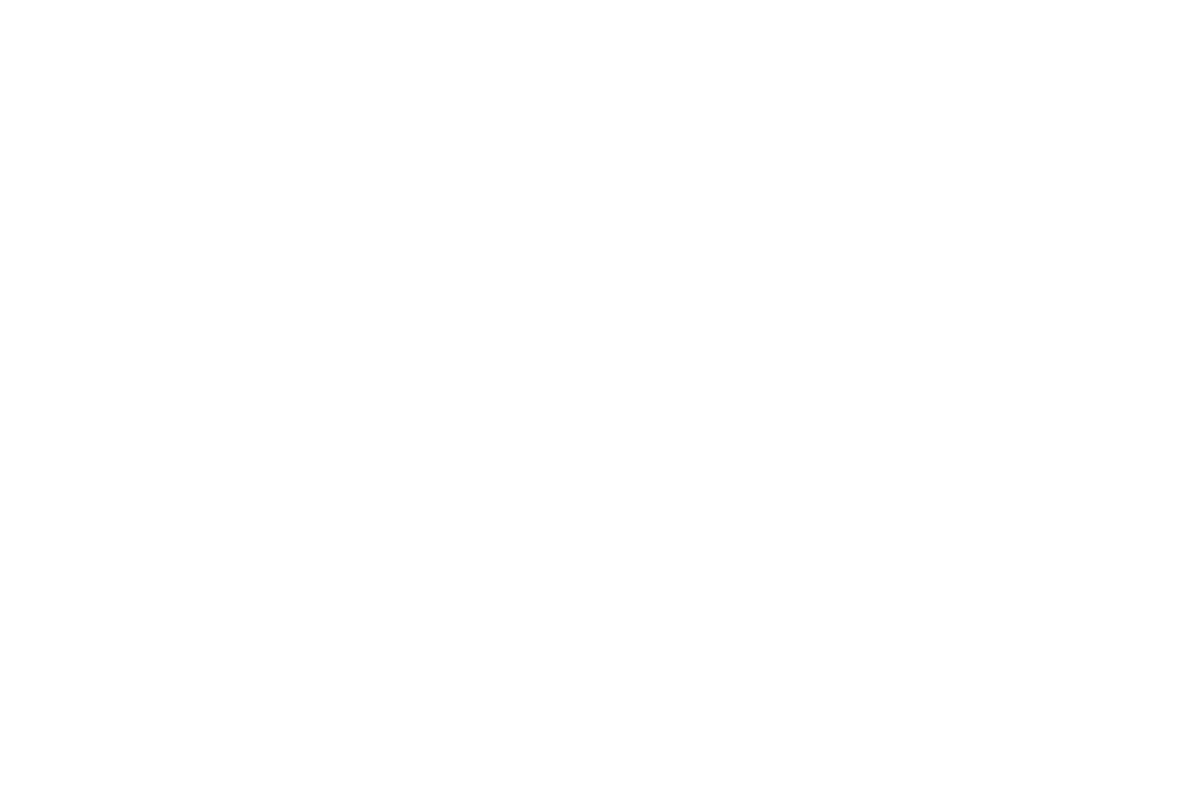

<IPython.core.display.Javascript object>


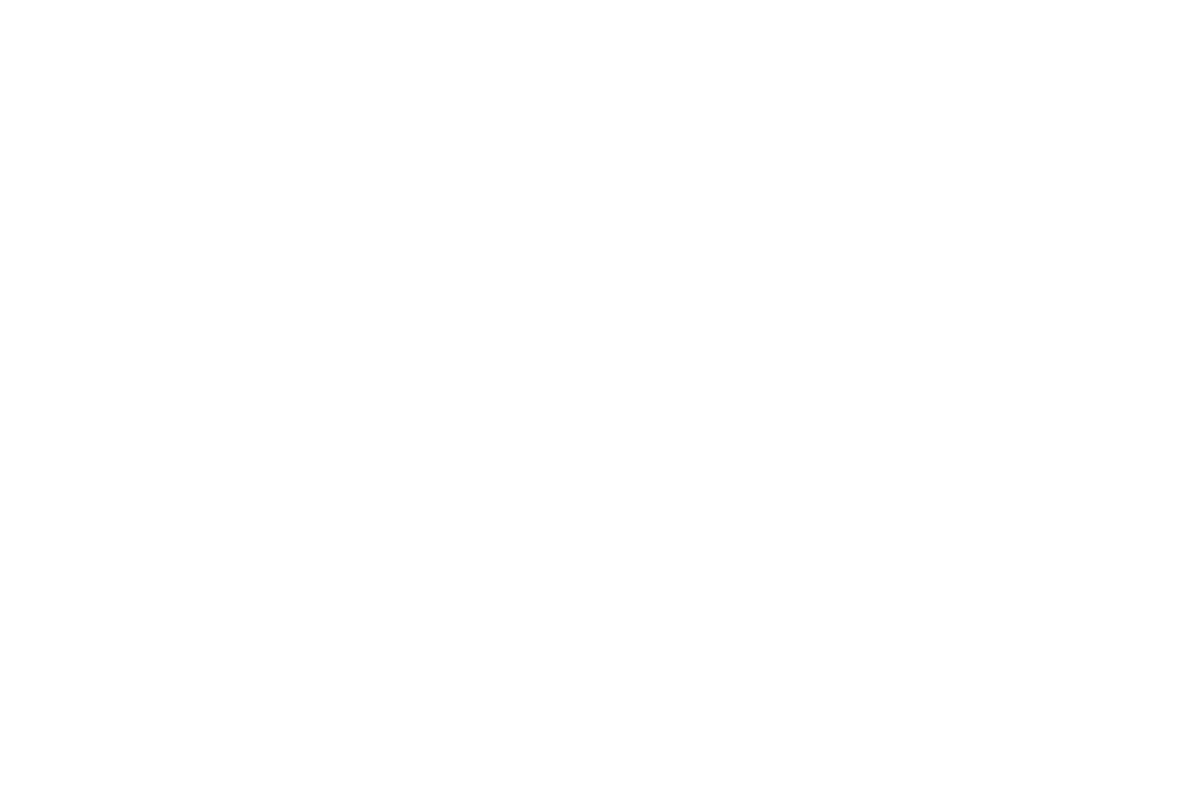

<IPython.core.display.Javascript object>


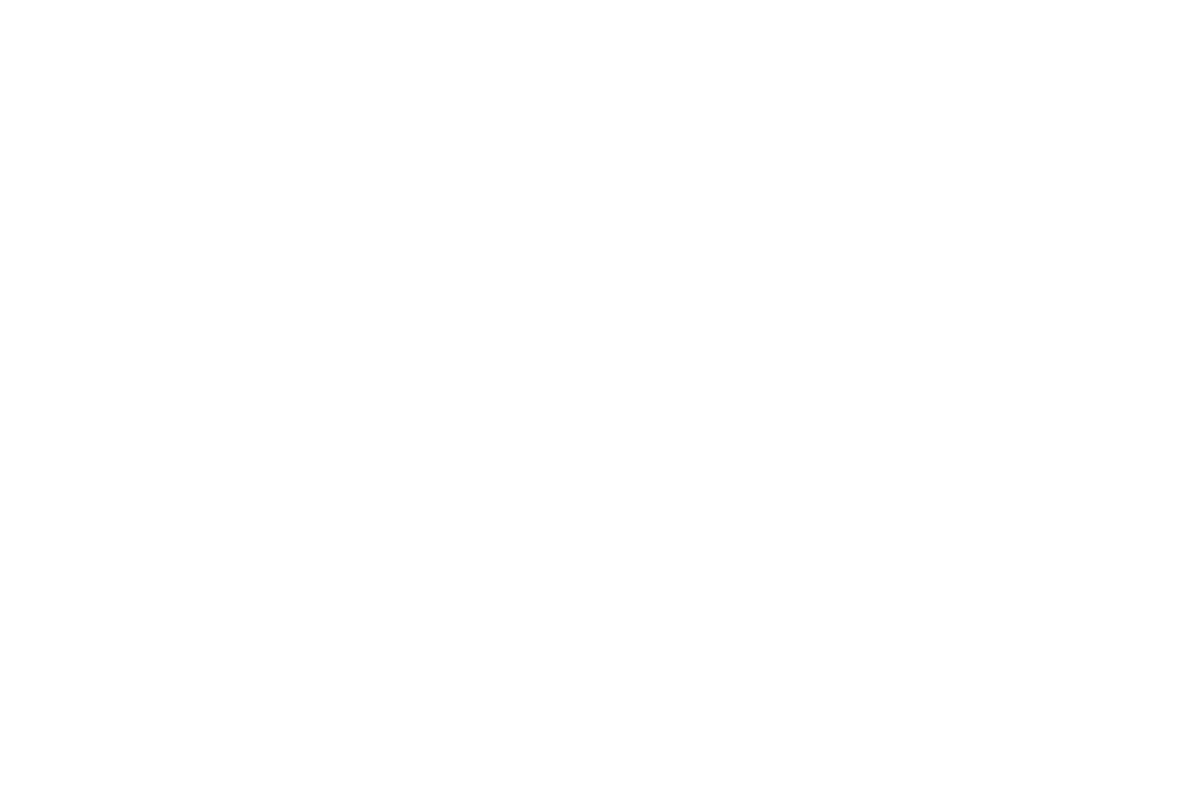

<IPython.core.display.Javascript object>


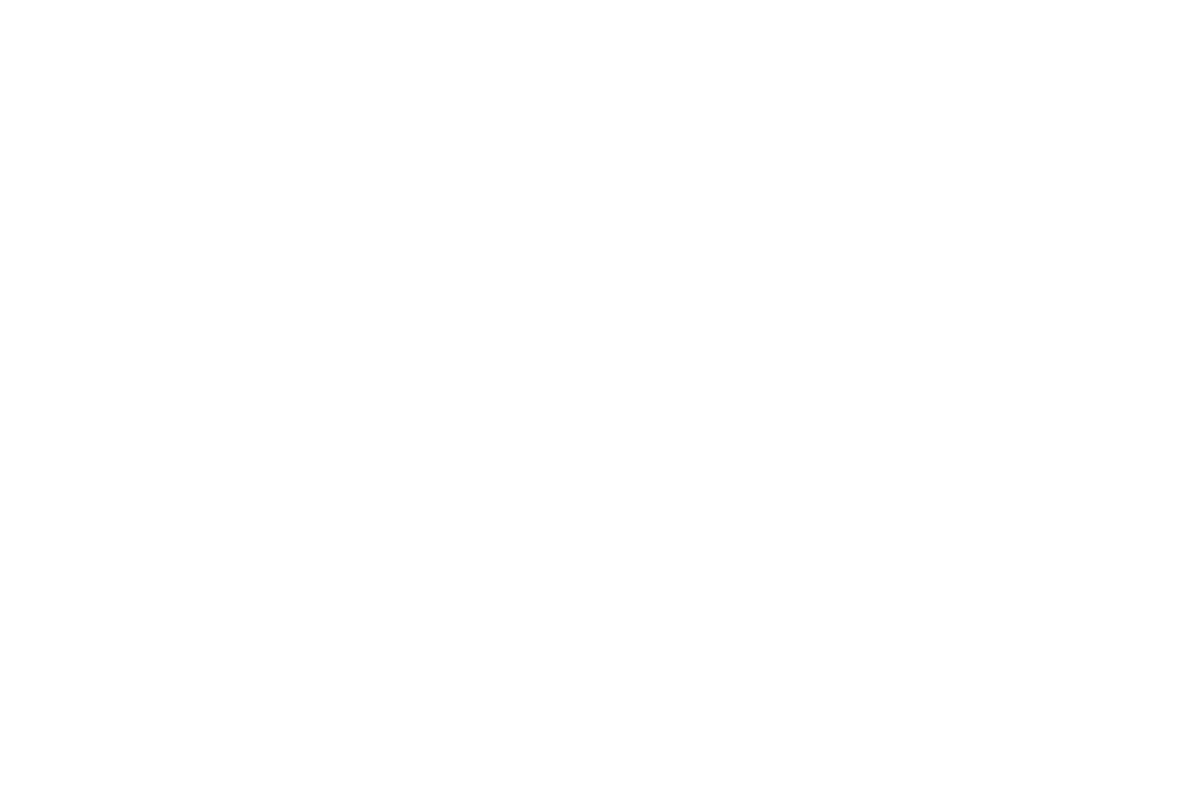

<IPython.core.display.Javascript object>


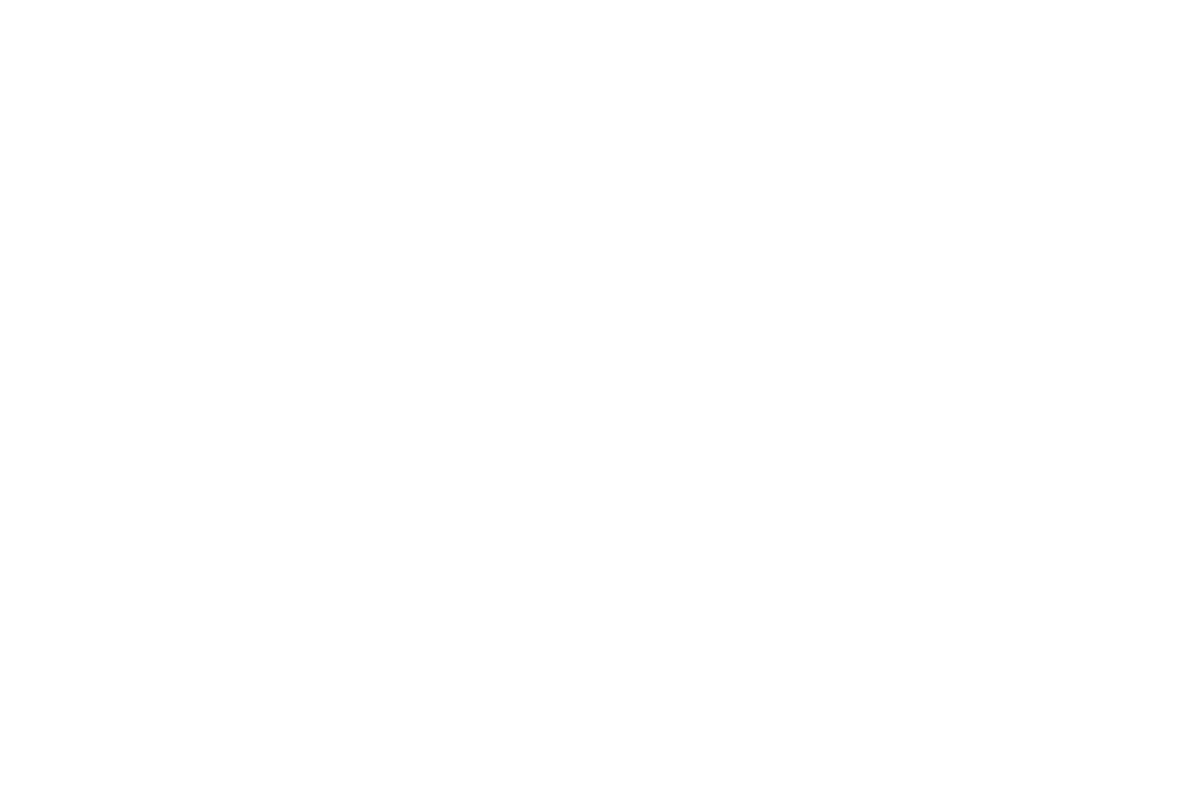

<IPython.core.display.Javascript object>


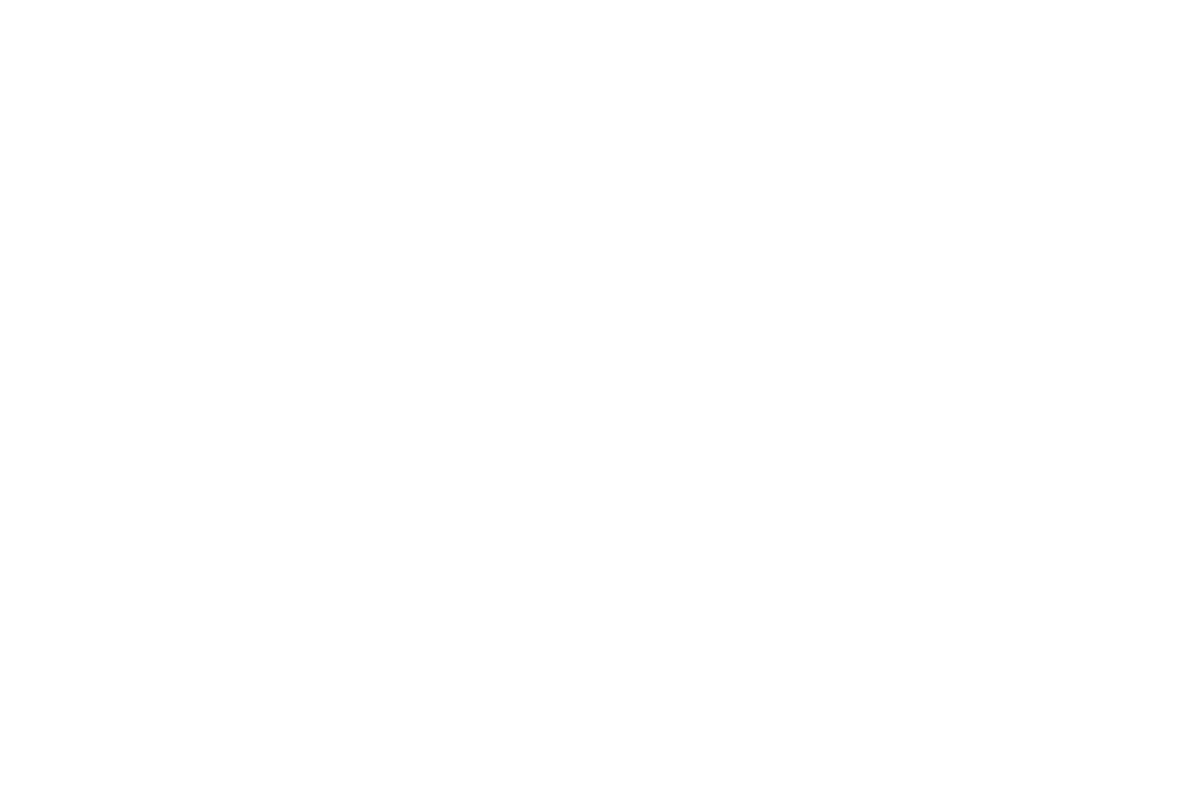

<IPython.core.display.Javascript object>


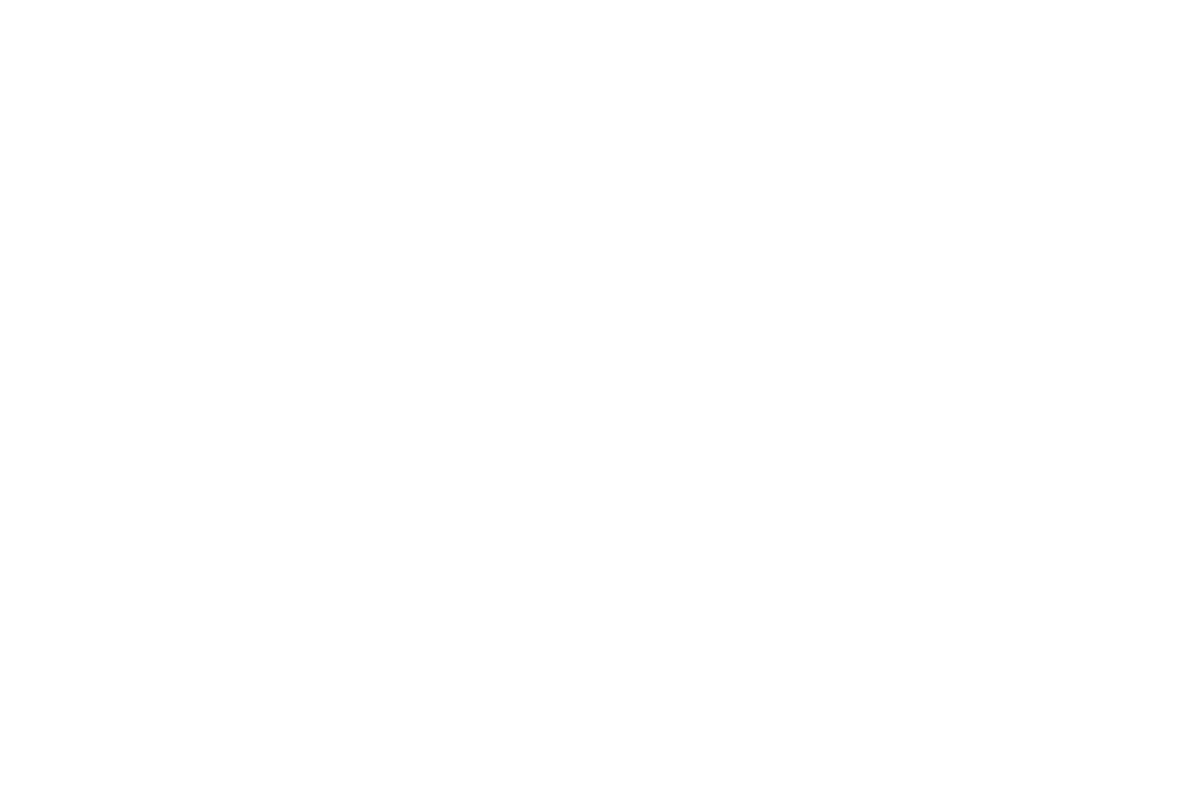

<IPython.core.display.Javascript object>


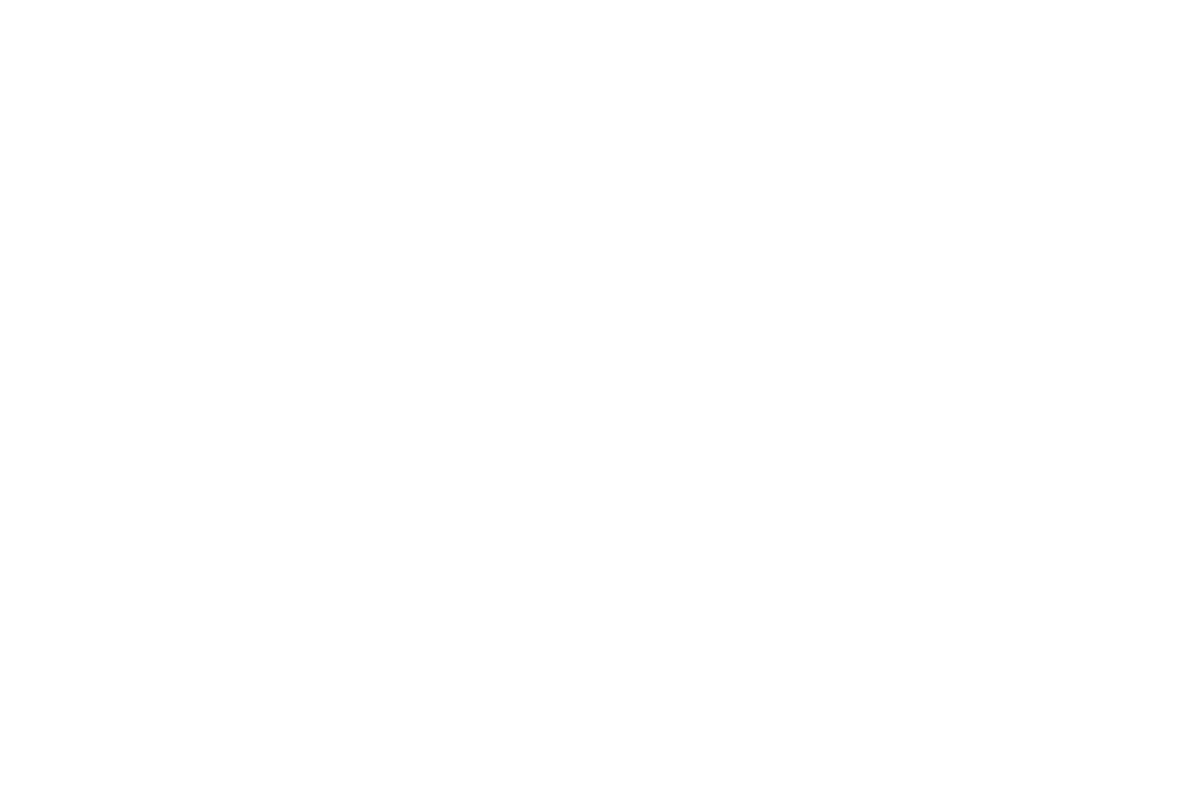

<IPython.core.display.Javascript object>


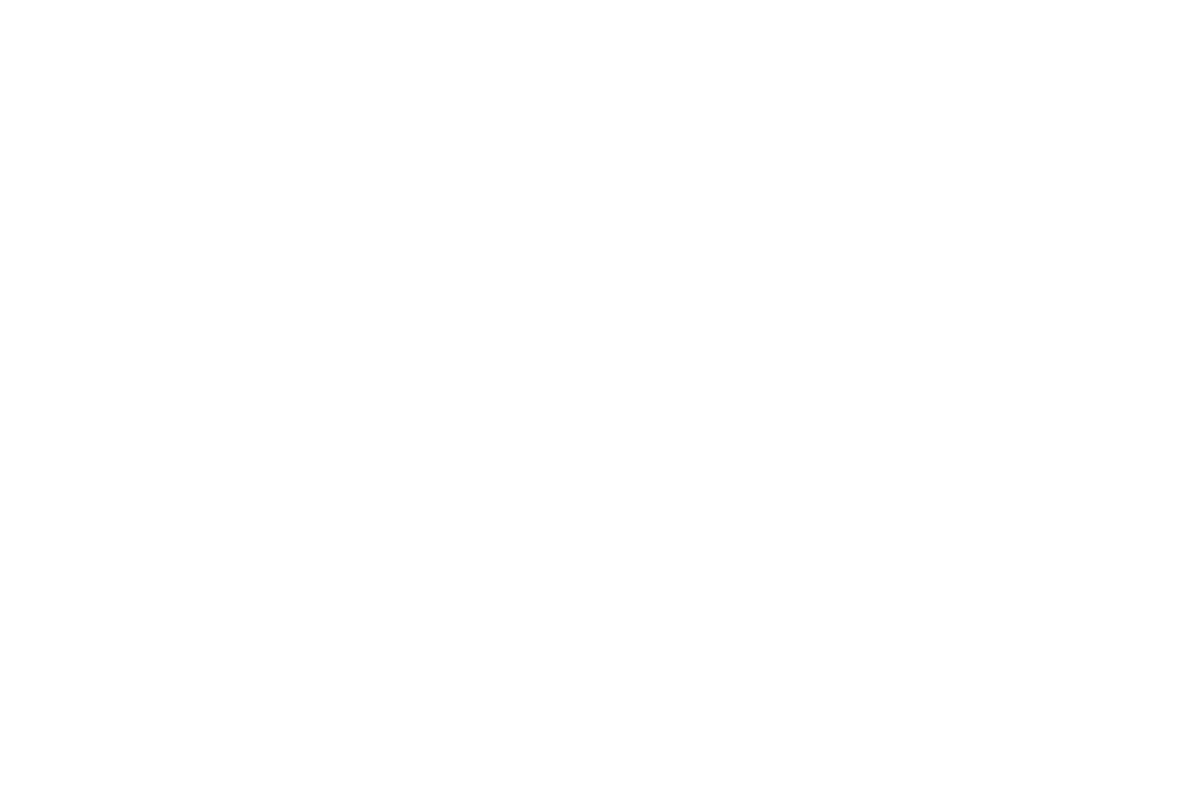

<IPython.core.display.Javascript object>


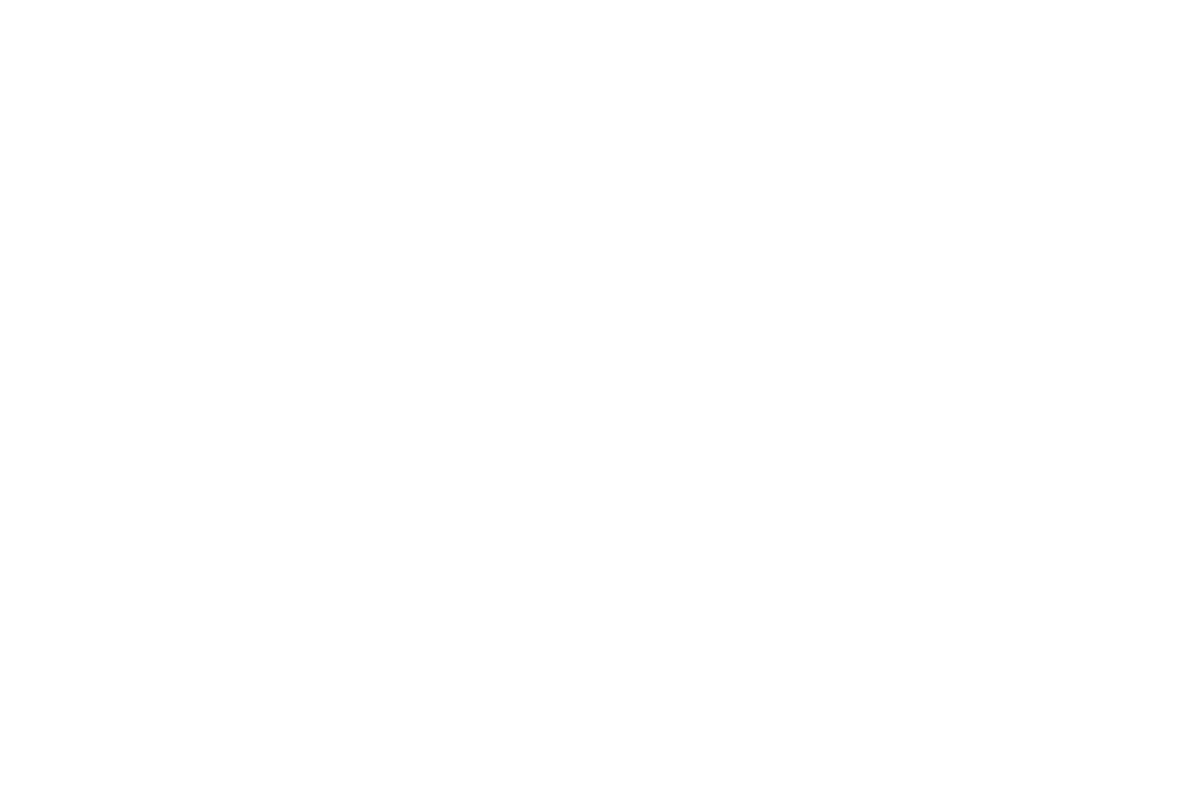

<IPython.core.display.Javascript object>


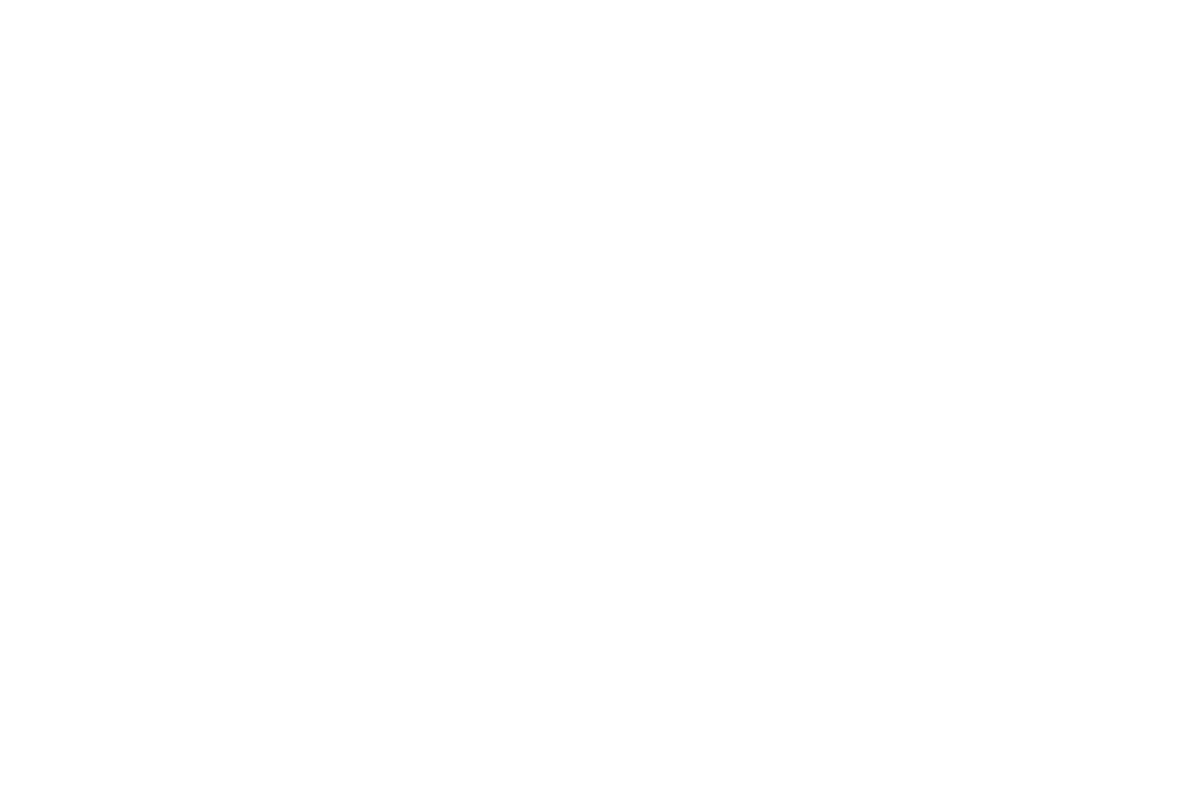

<IPython.core.display.Javascript object>


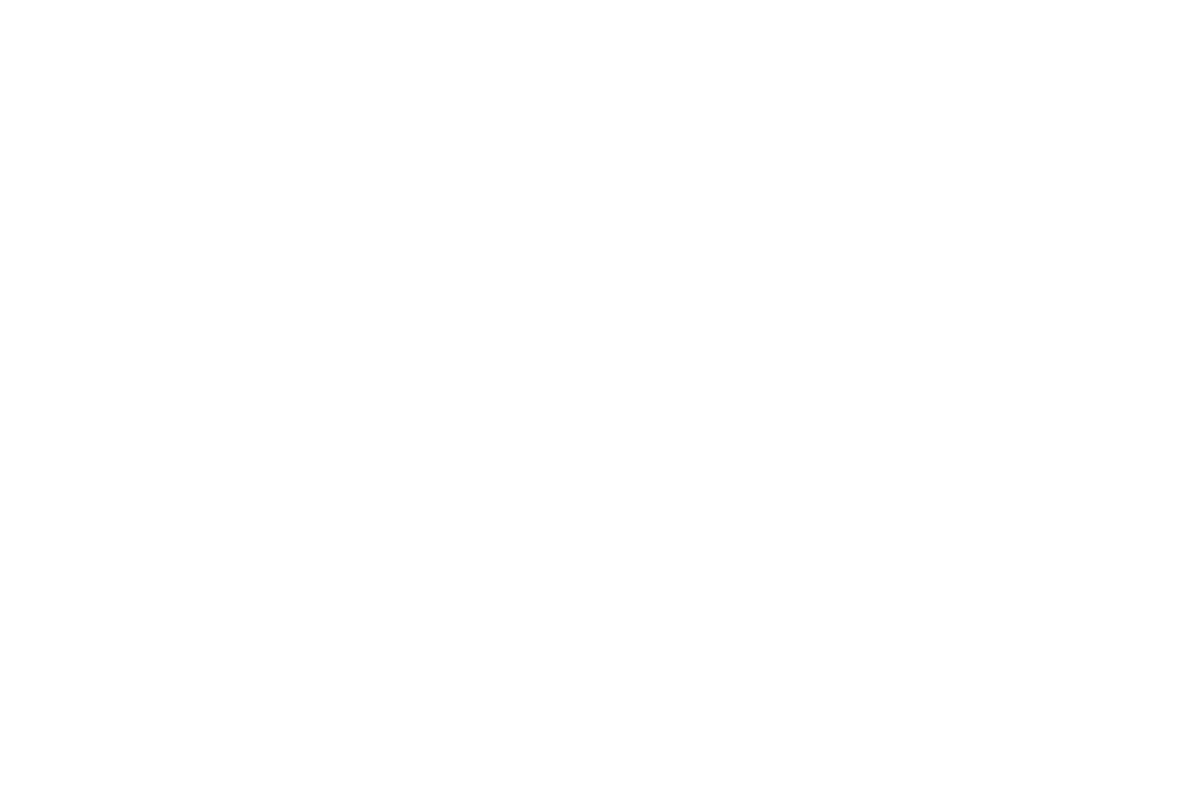

<IPython.core.display.Javascript object>


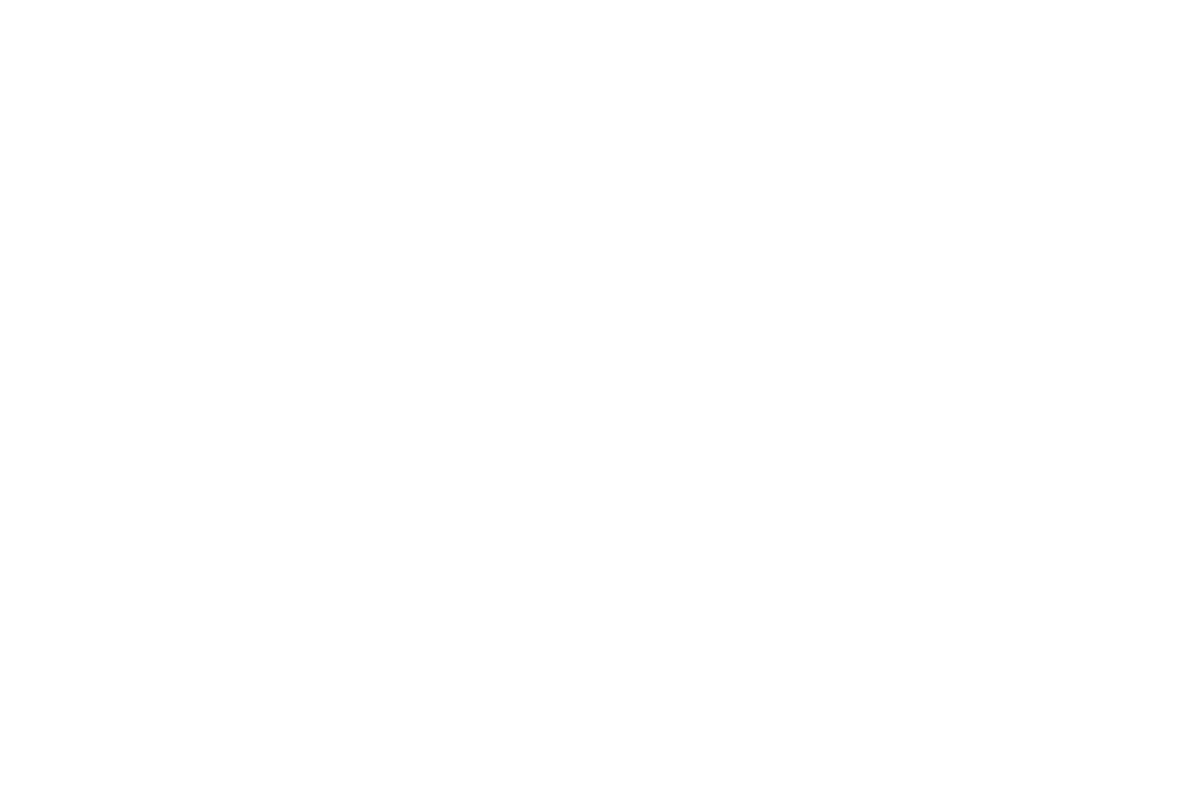

<IPython.core.display.Javascript object>


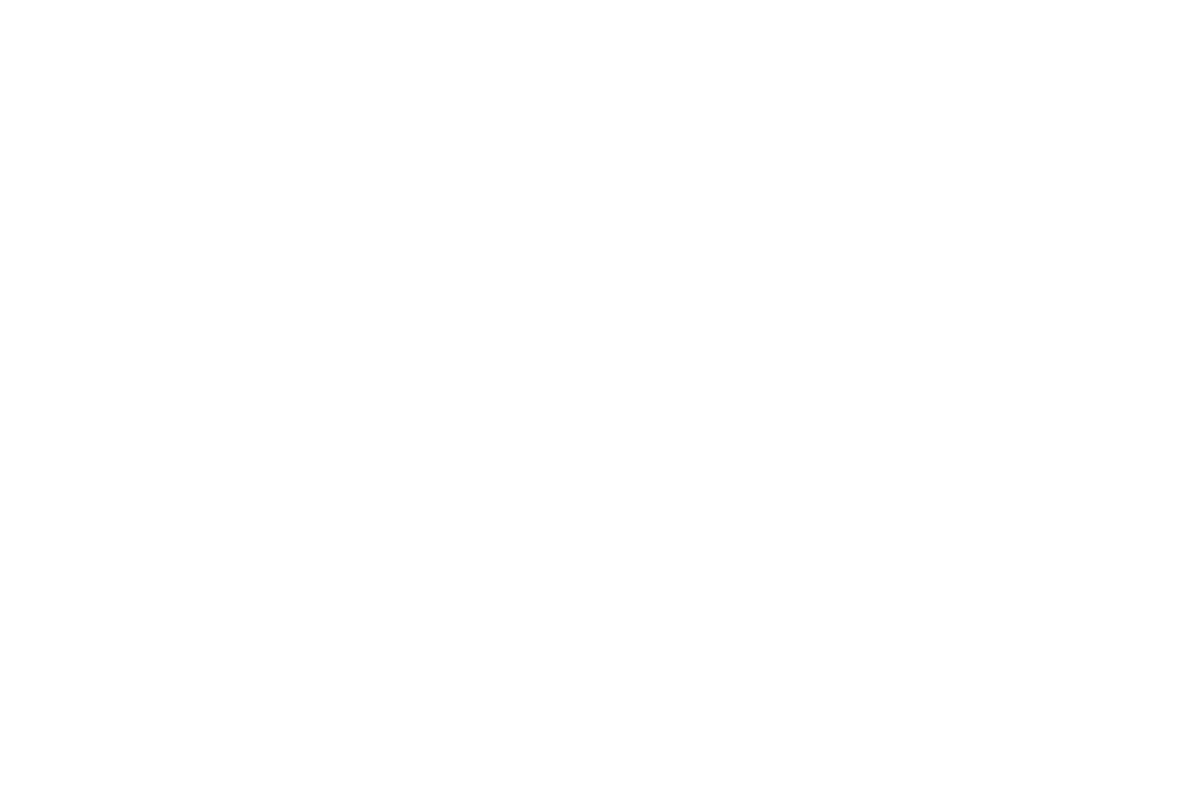

<IPython.core.display.Javascript object>


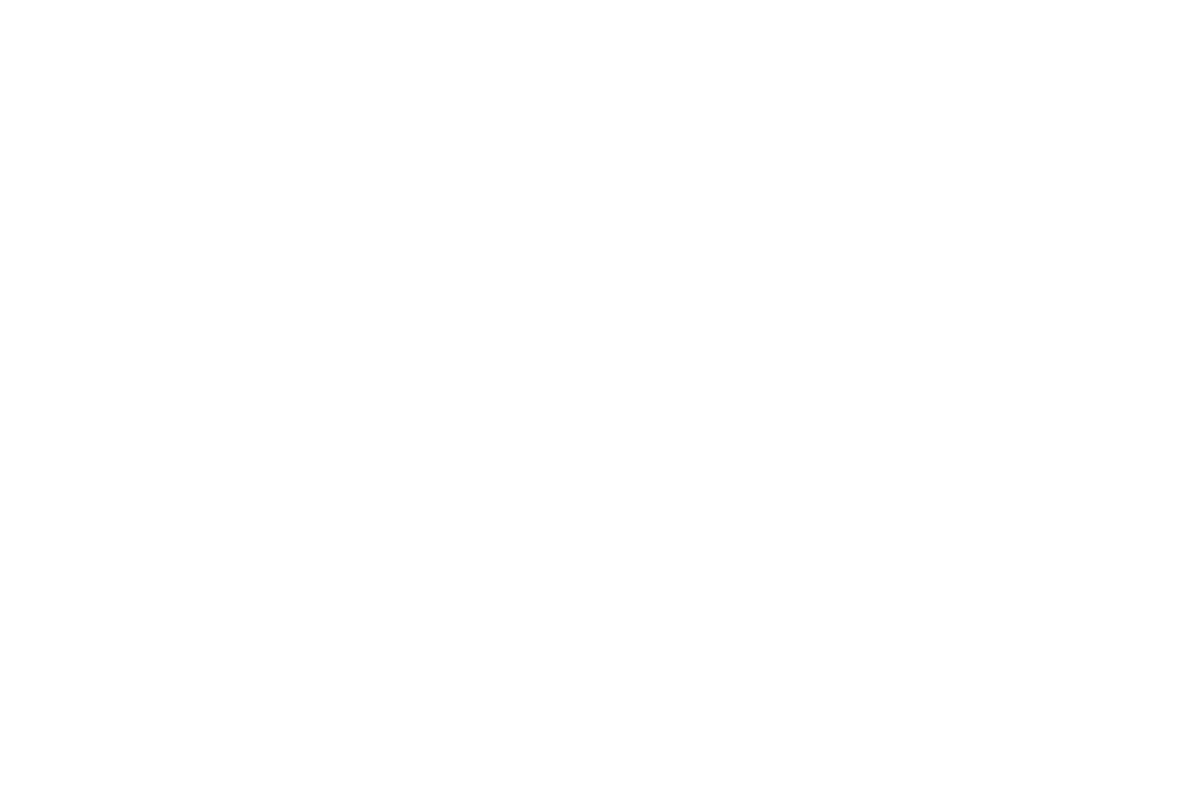

<IPython.core.display.Javascript object>


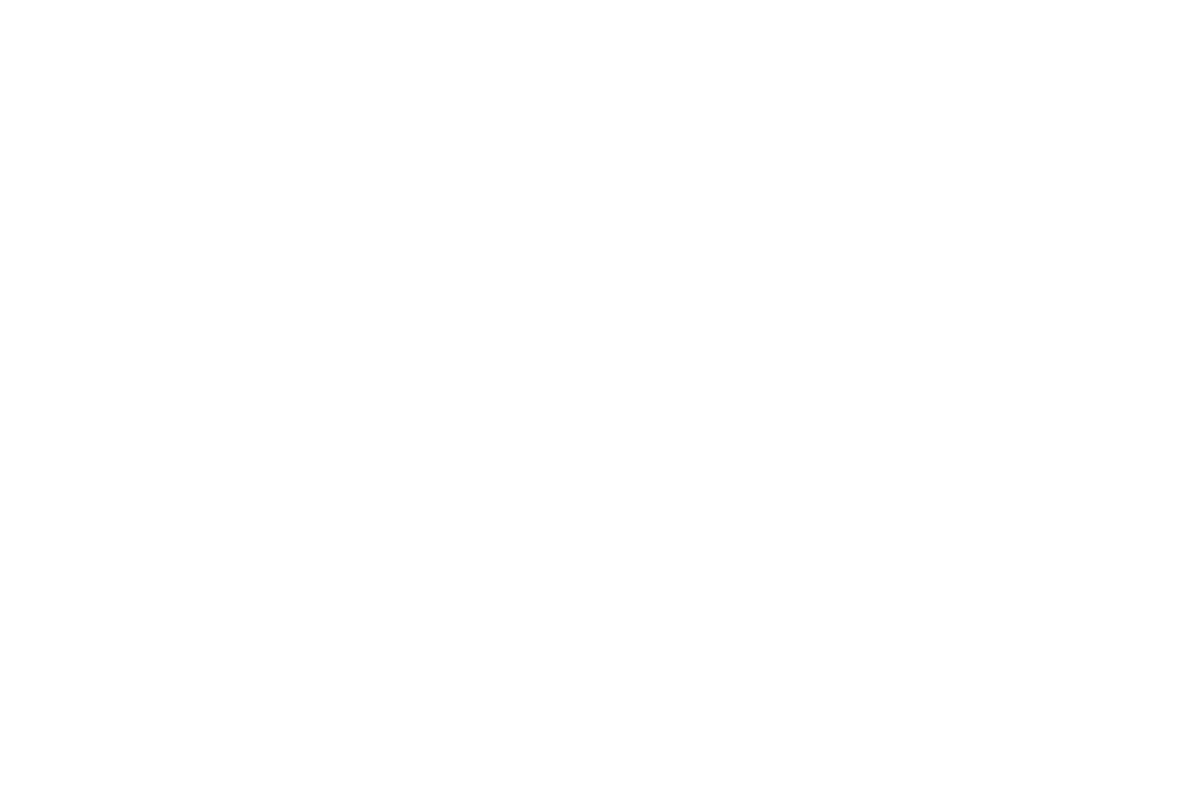

<IPython.core.display.Javascript object>


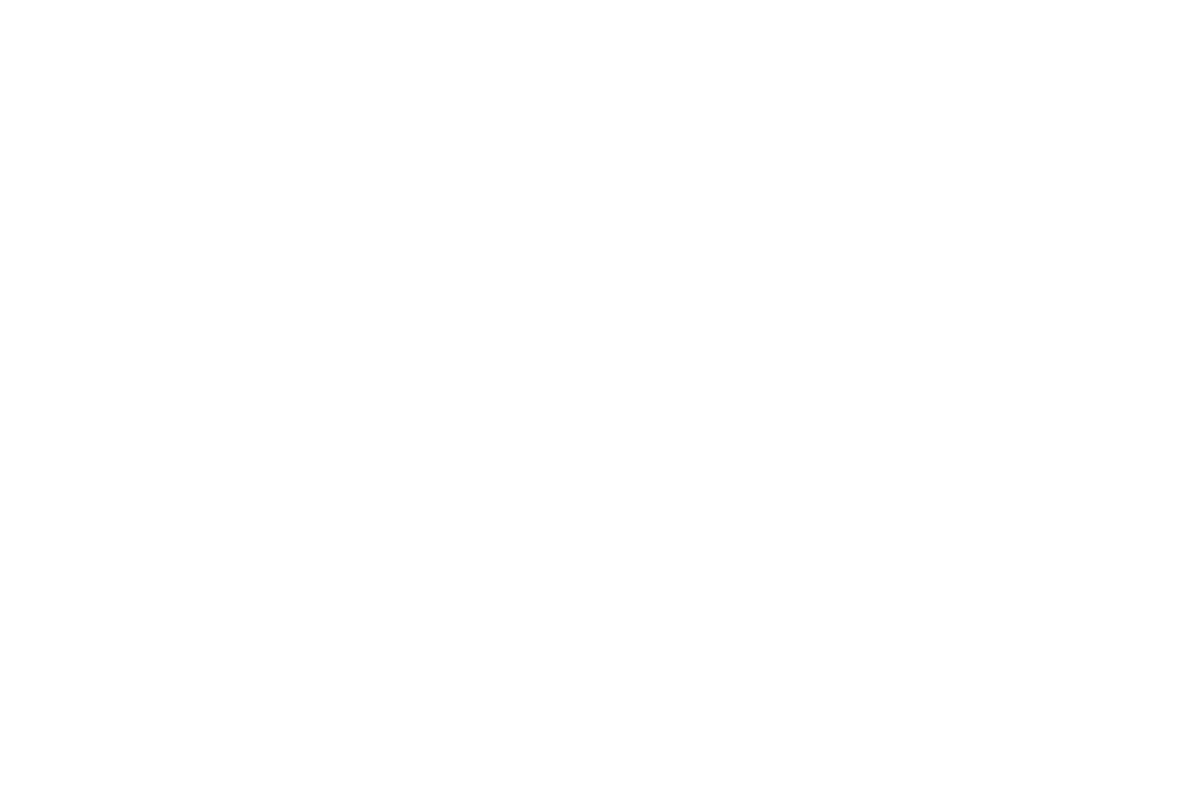

<IPython.core.display.Javascript object>


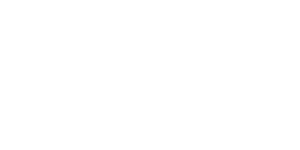

<IPython.core.display.Javascript object>


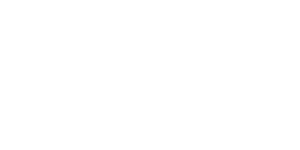

<IPython.core.display.Javascript object>


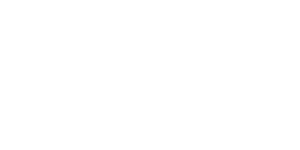

<IPython.core.display.Javascript object>


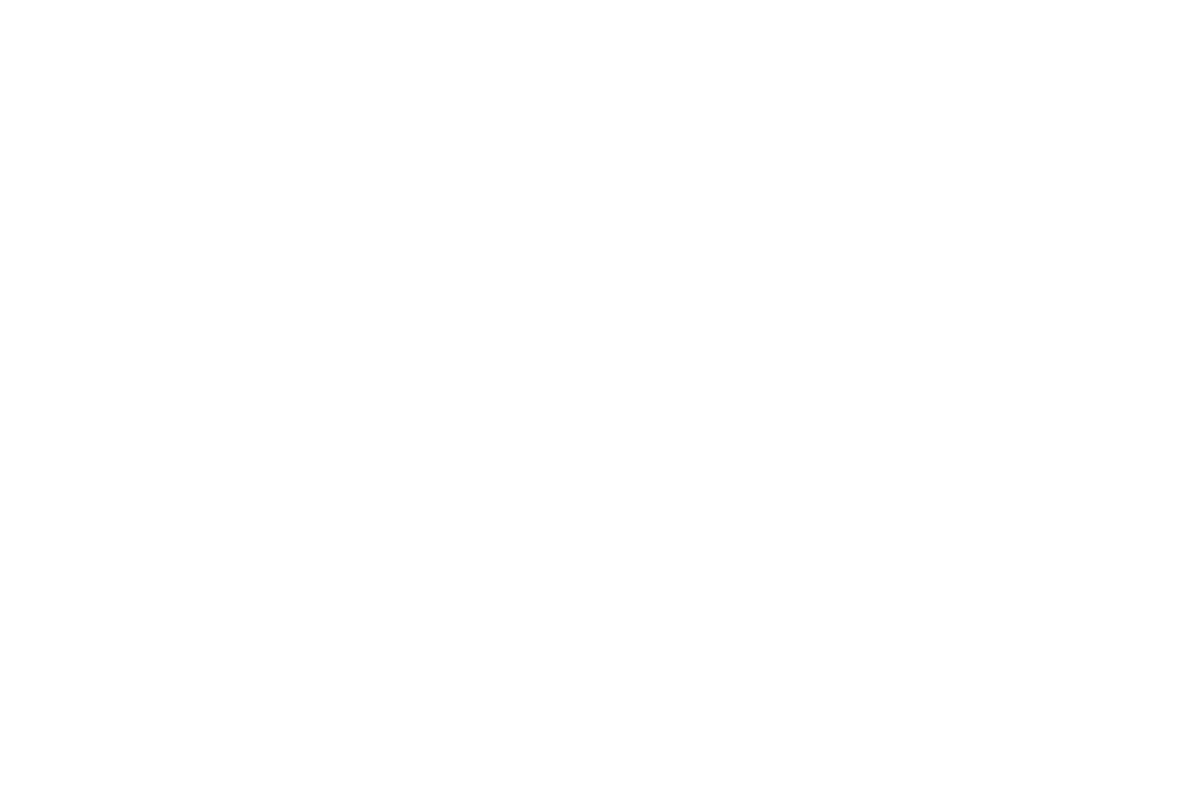

<IPython.core.display.Javascript object>


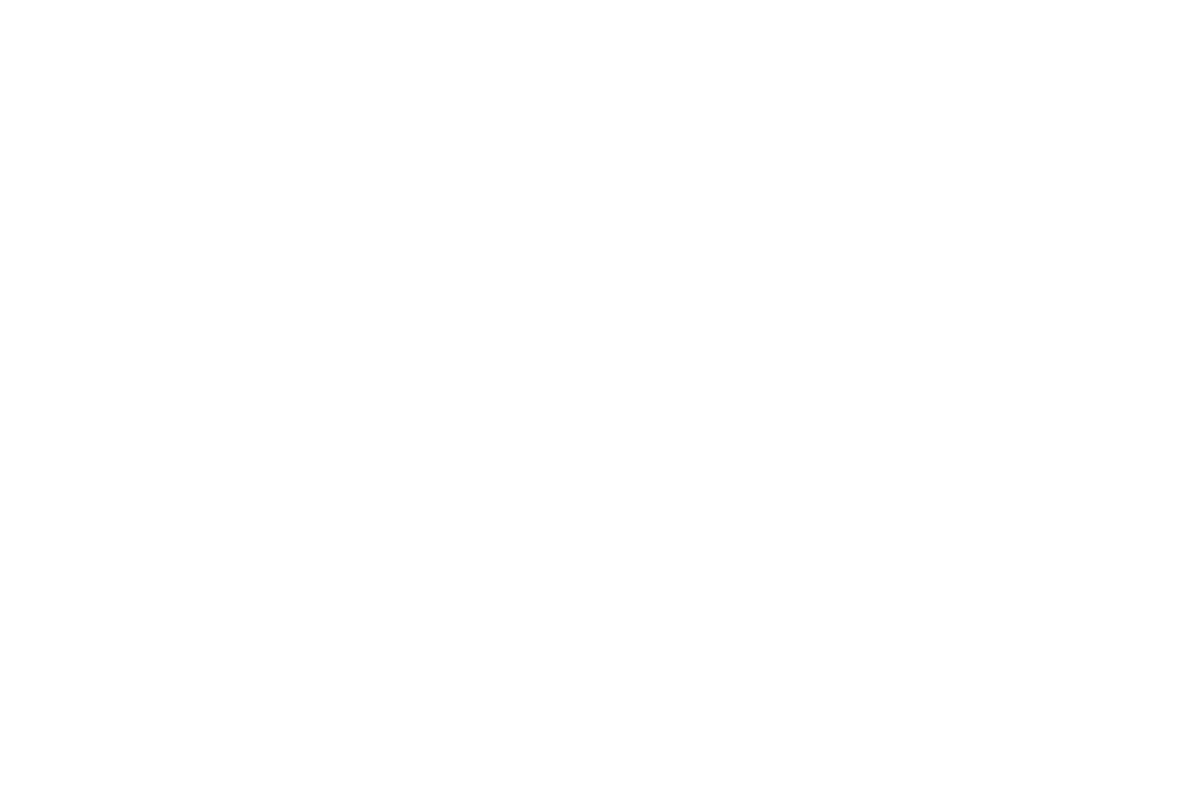

<IPython.core.display.Javascript object>


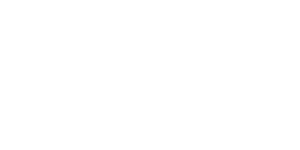

<IPython.core.display.Javascript object>


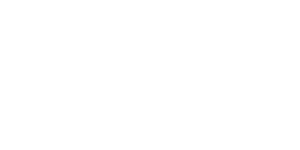

<IPython.core.display.Javascript object>


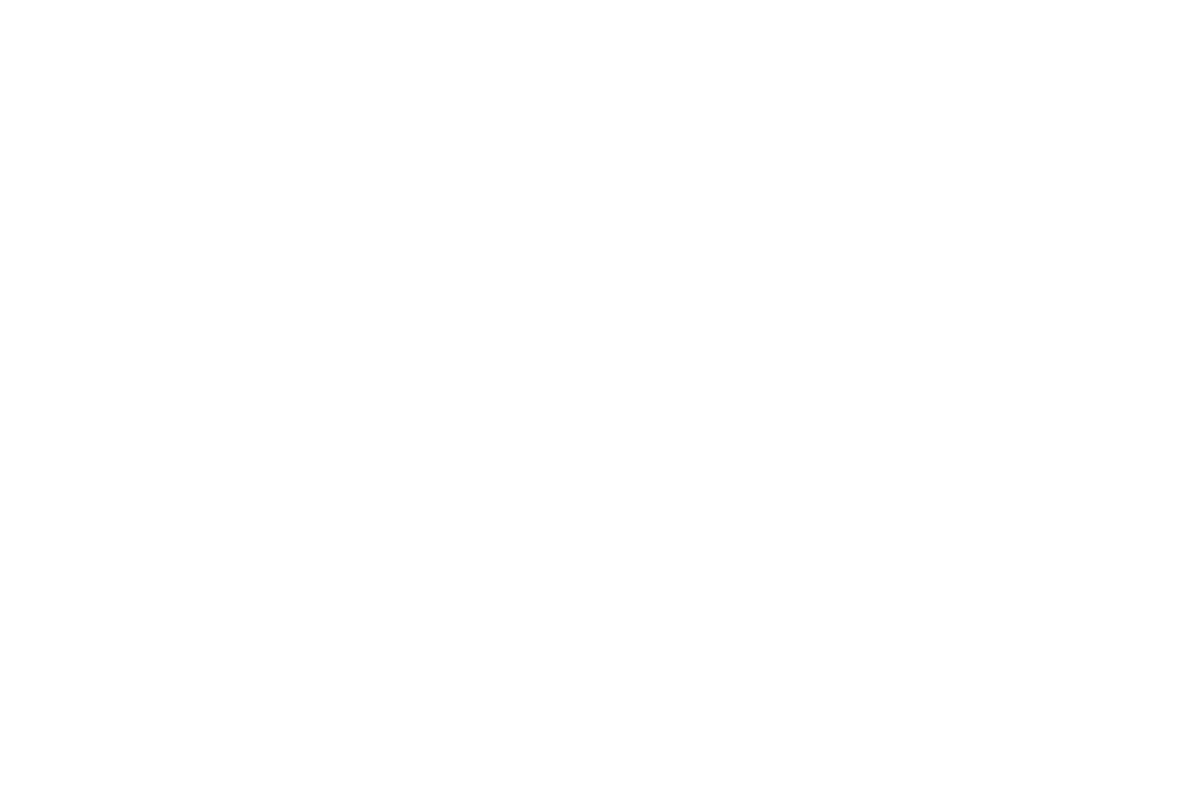

<IPython.core.display.Javascript object>


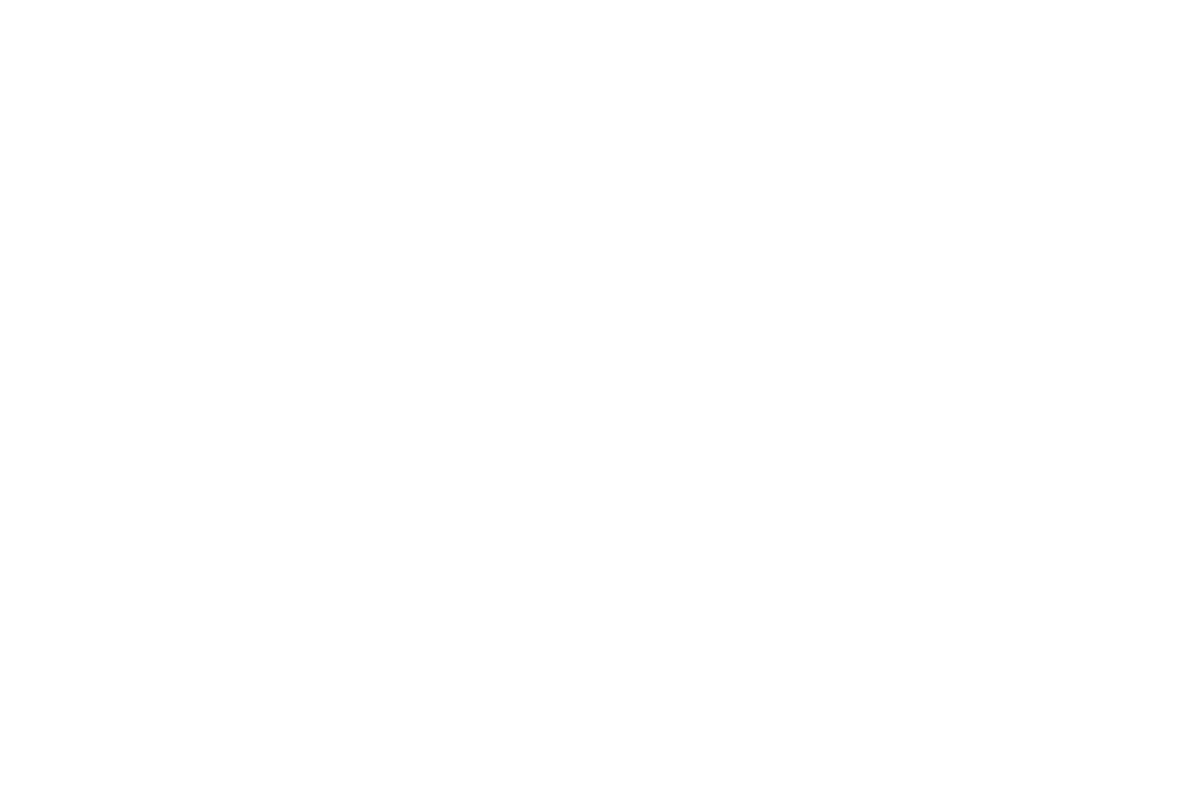

<IPython.core.display.Javascript object>


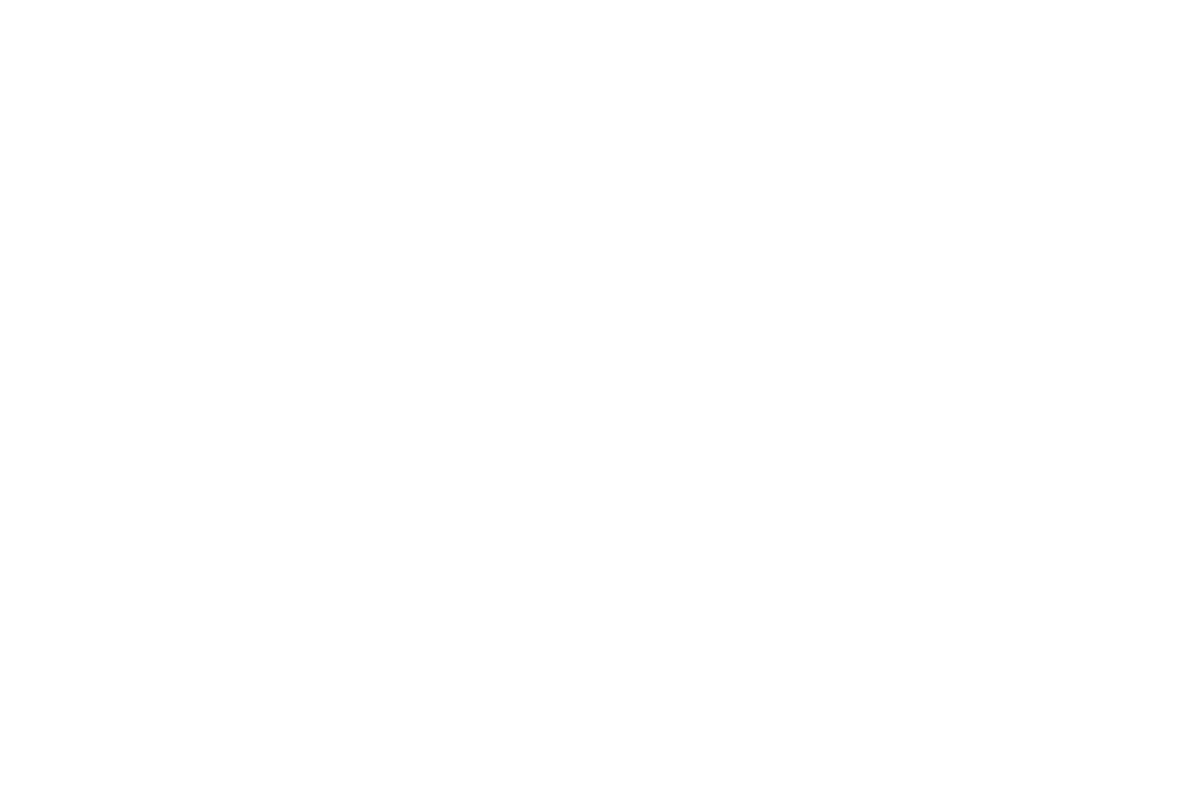

<IPython.core.display.Javascript object>


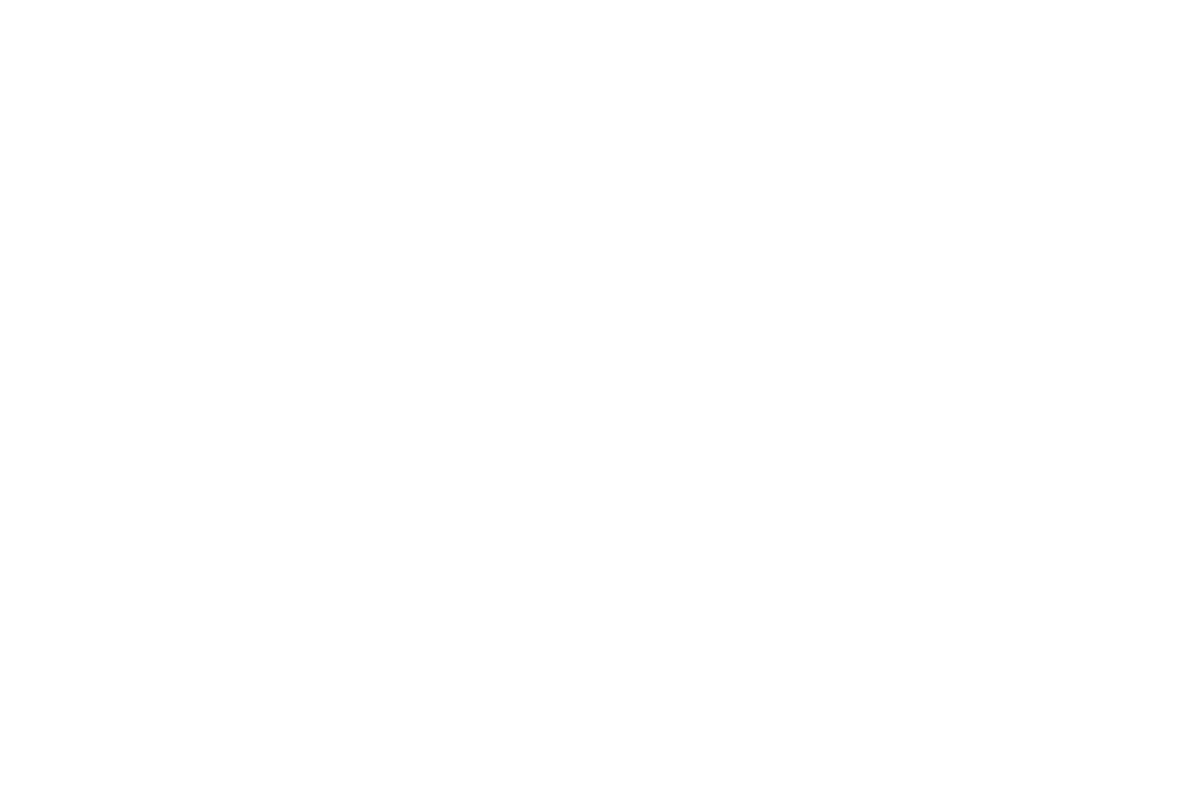

<IPython.core.display.Javascript object>


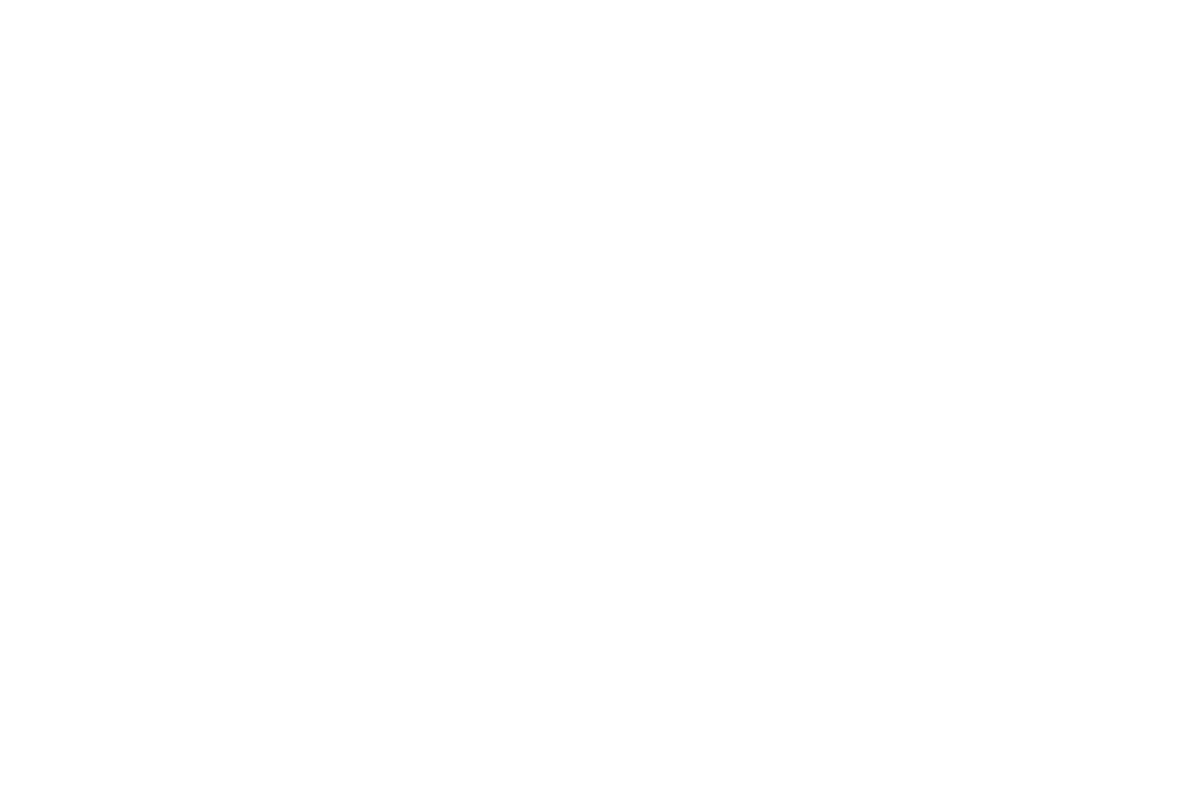

<IPython.core.display.Javascript object>


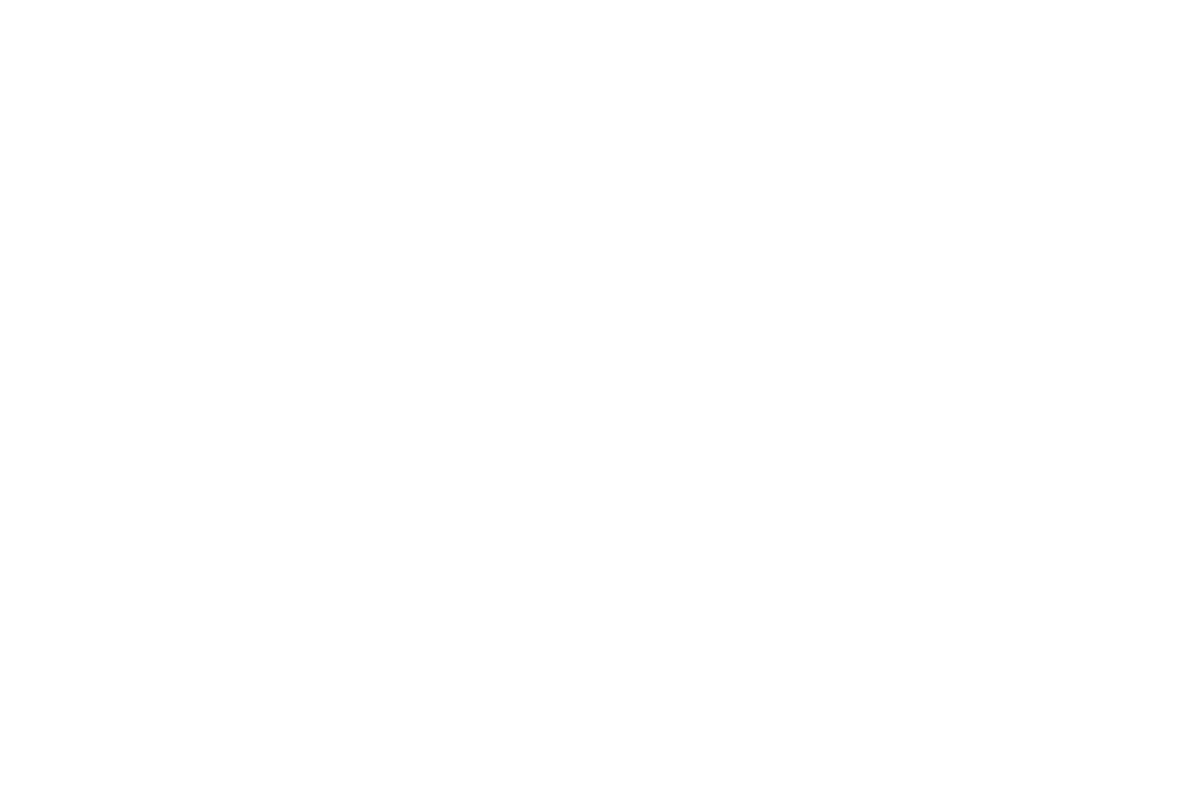

<IPython.core.display.Javascript object>


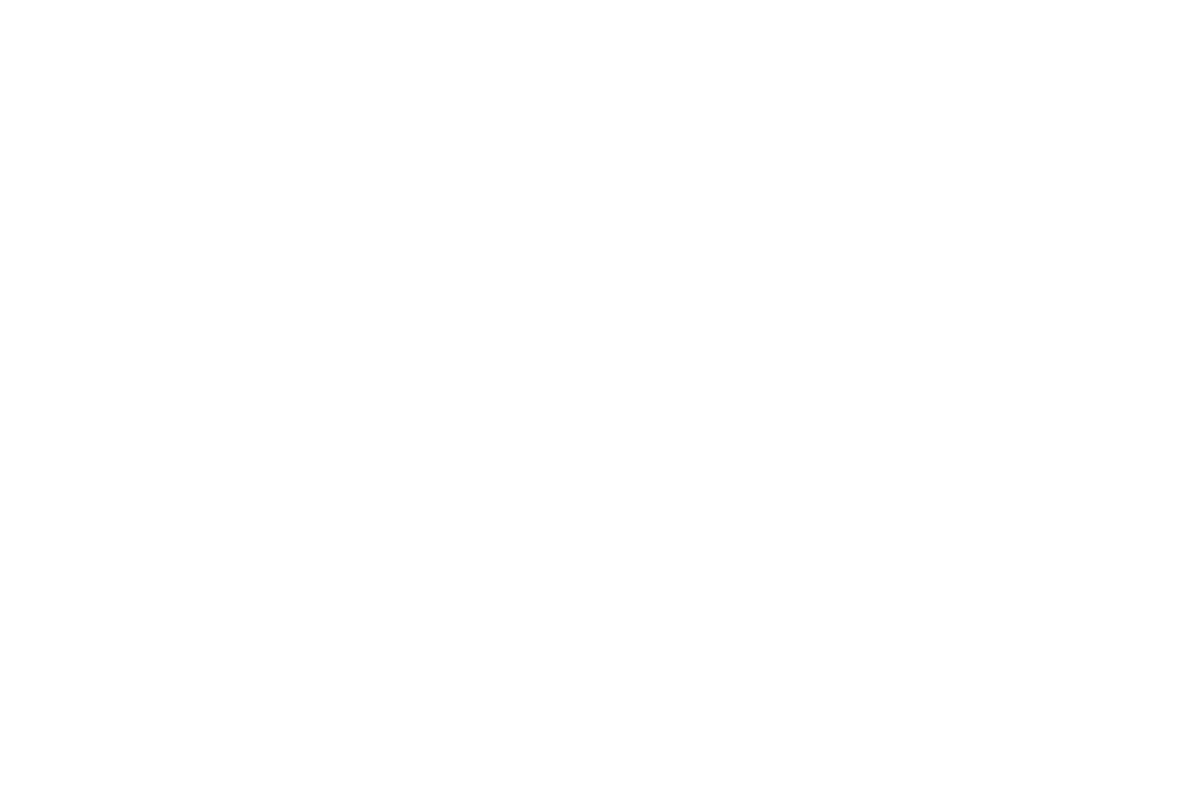

<IPython.core.display.Javascript object>


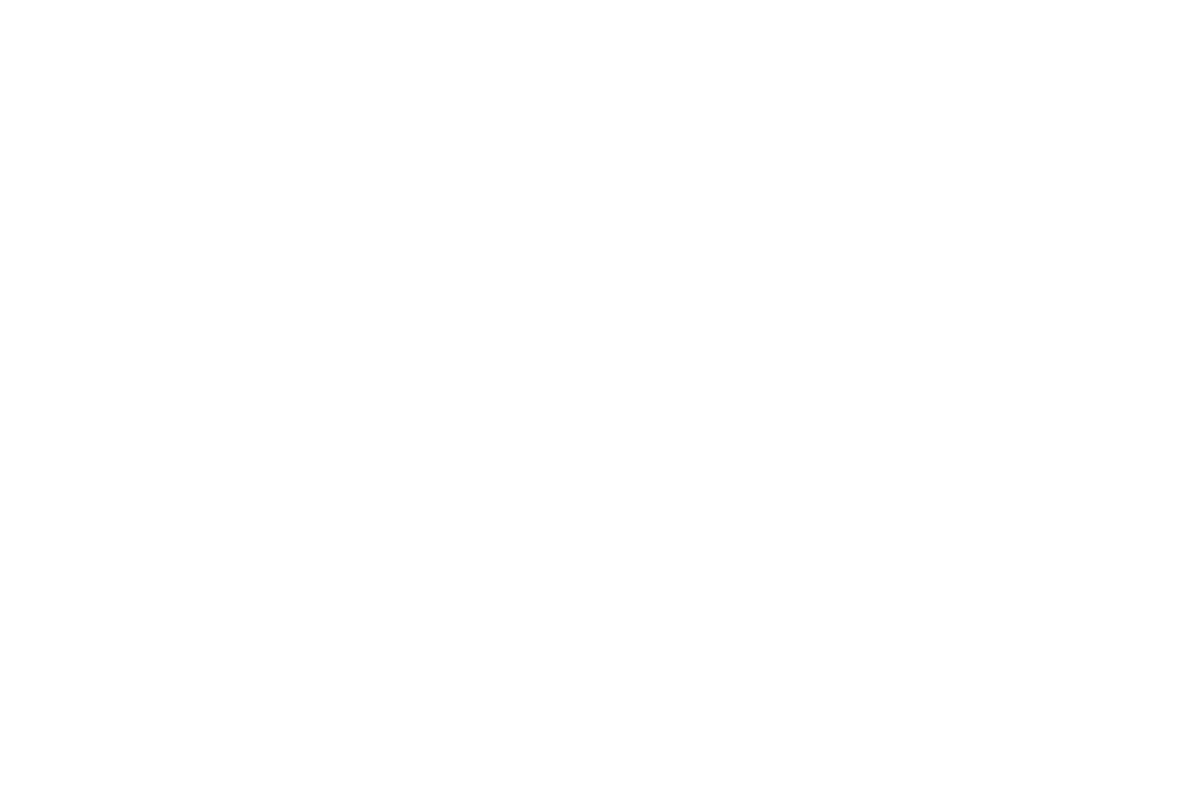

<IPython.core.display.Javascript object>


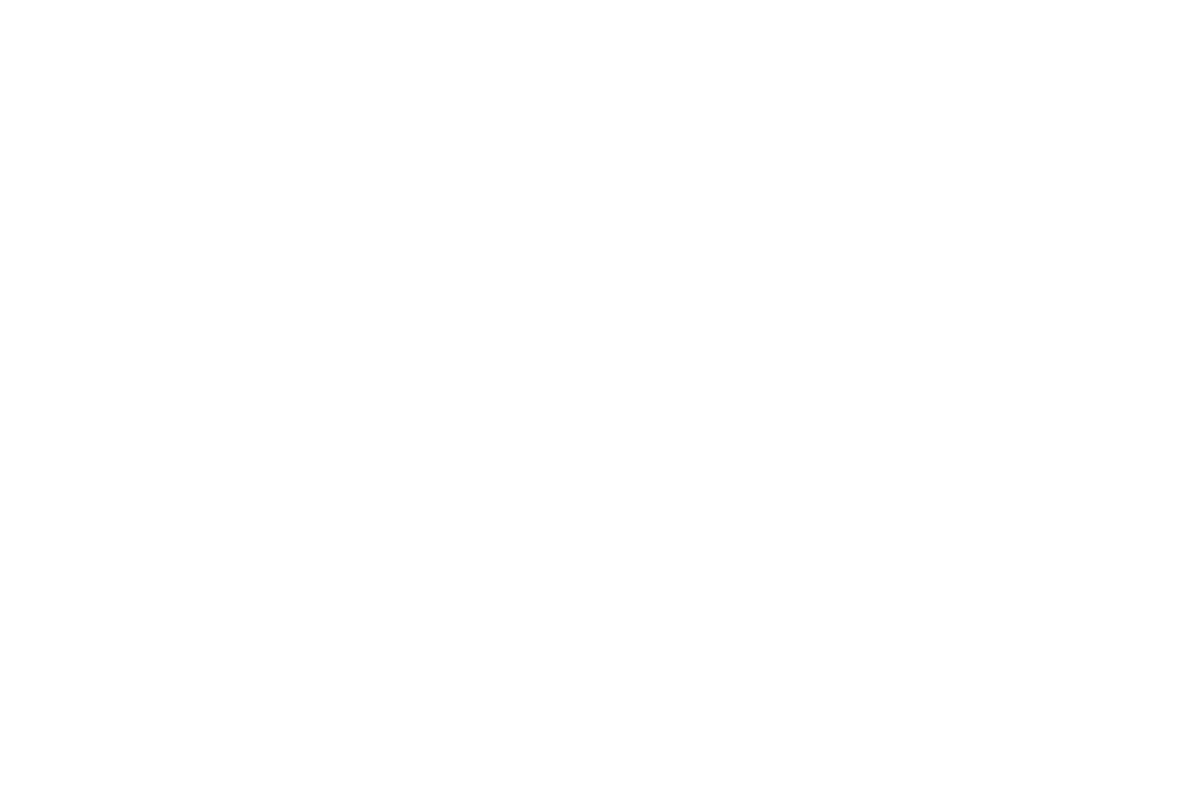

<IPython.core.display.Javascript object>


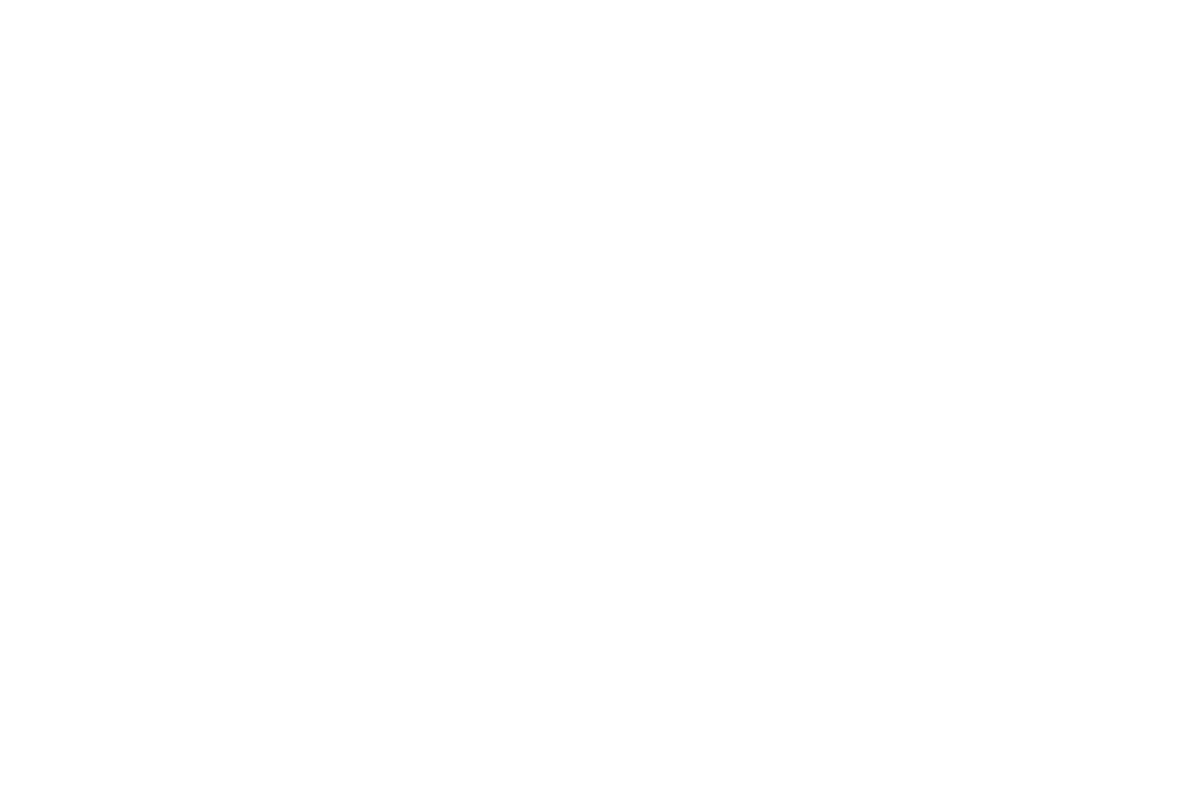

<IPython.core.display.Javascript object>


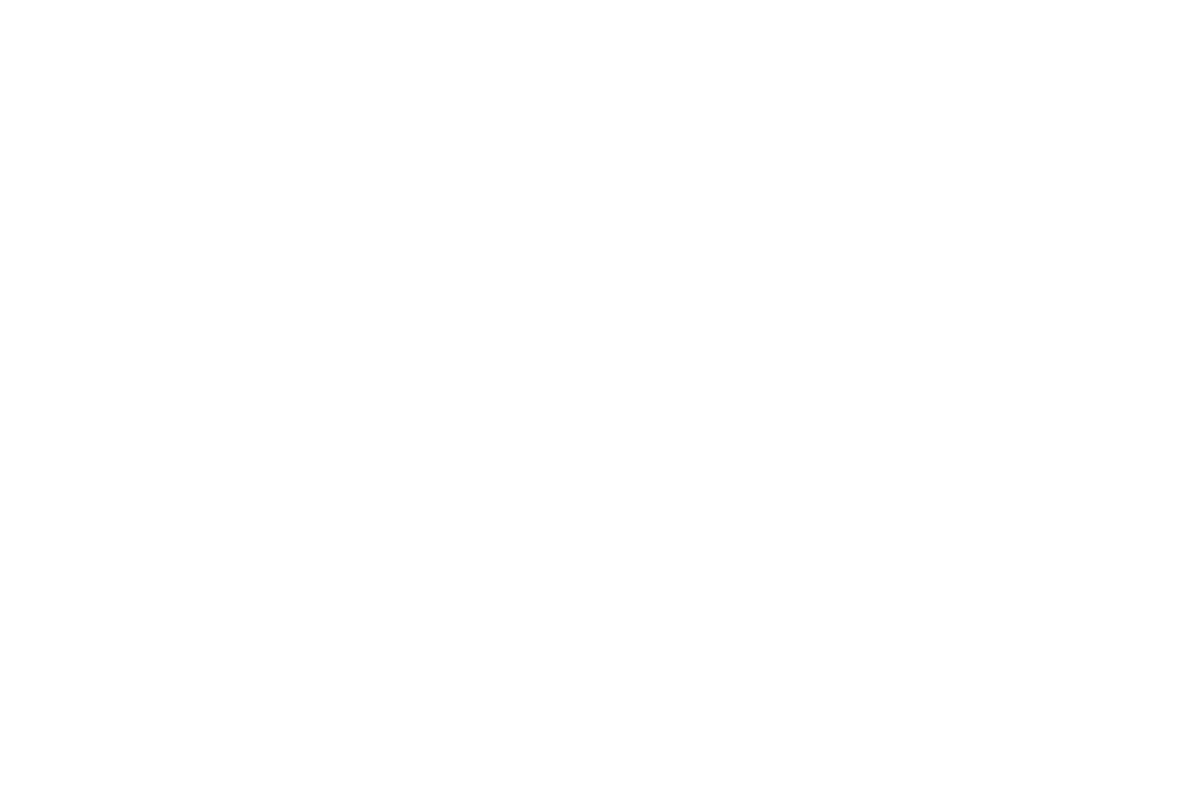

<IPython.core.display.Javascript object>


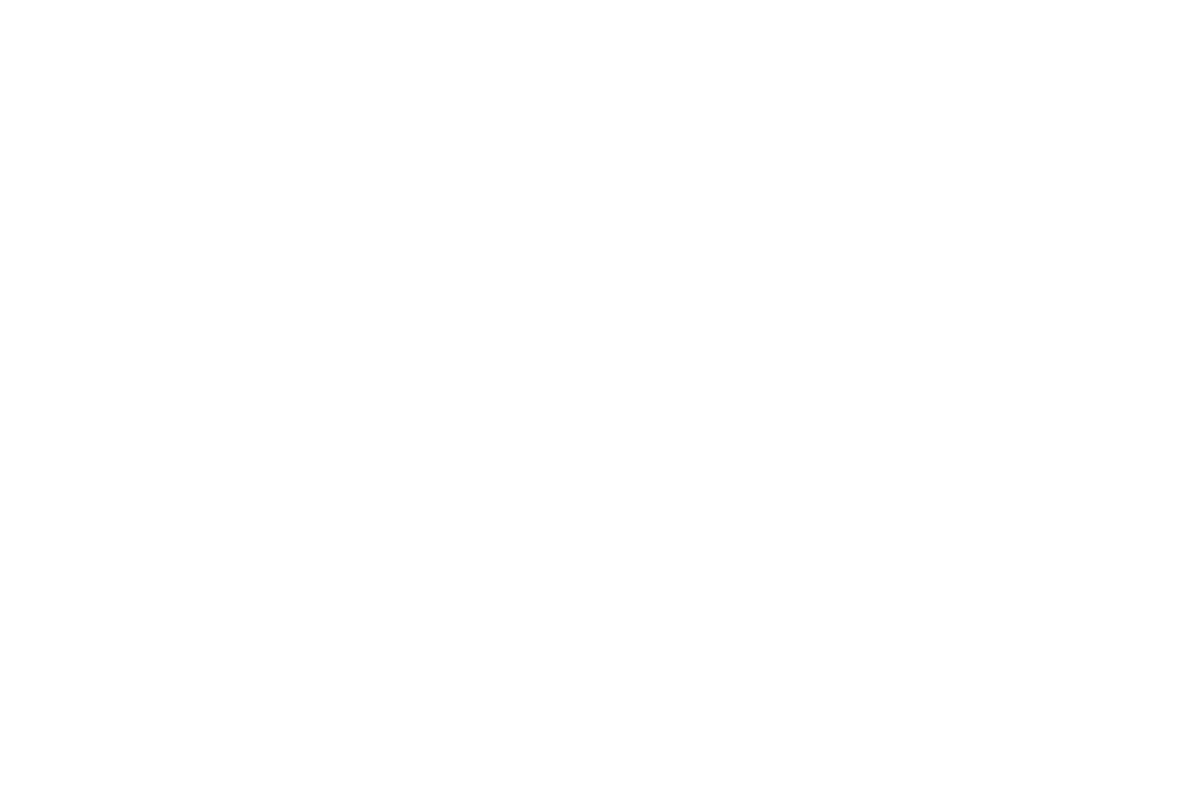

<IPython.core.display.Javascript object>


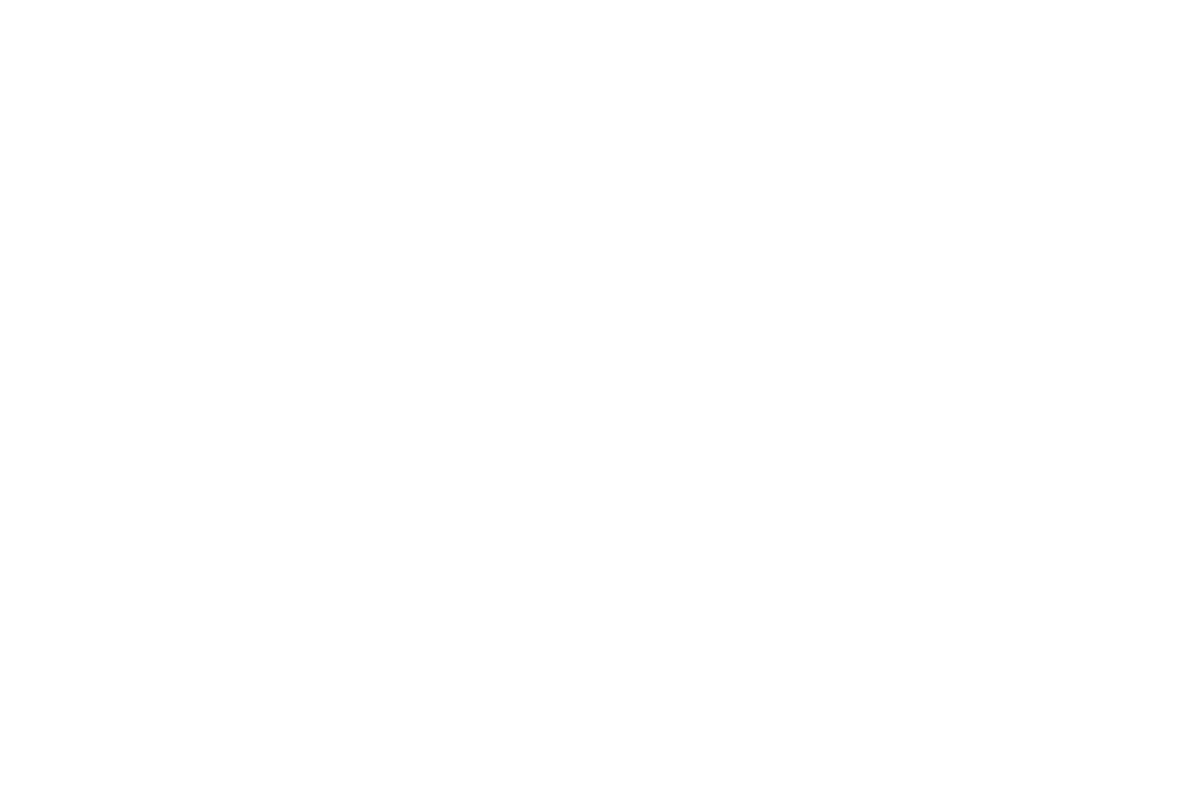

<IPython.core.display.Javascript object>


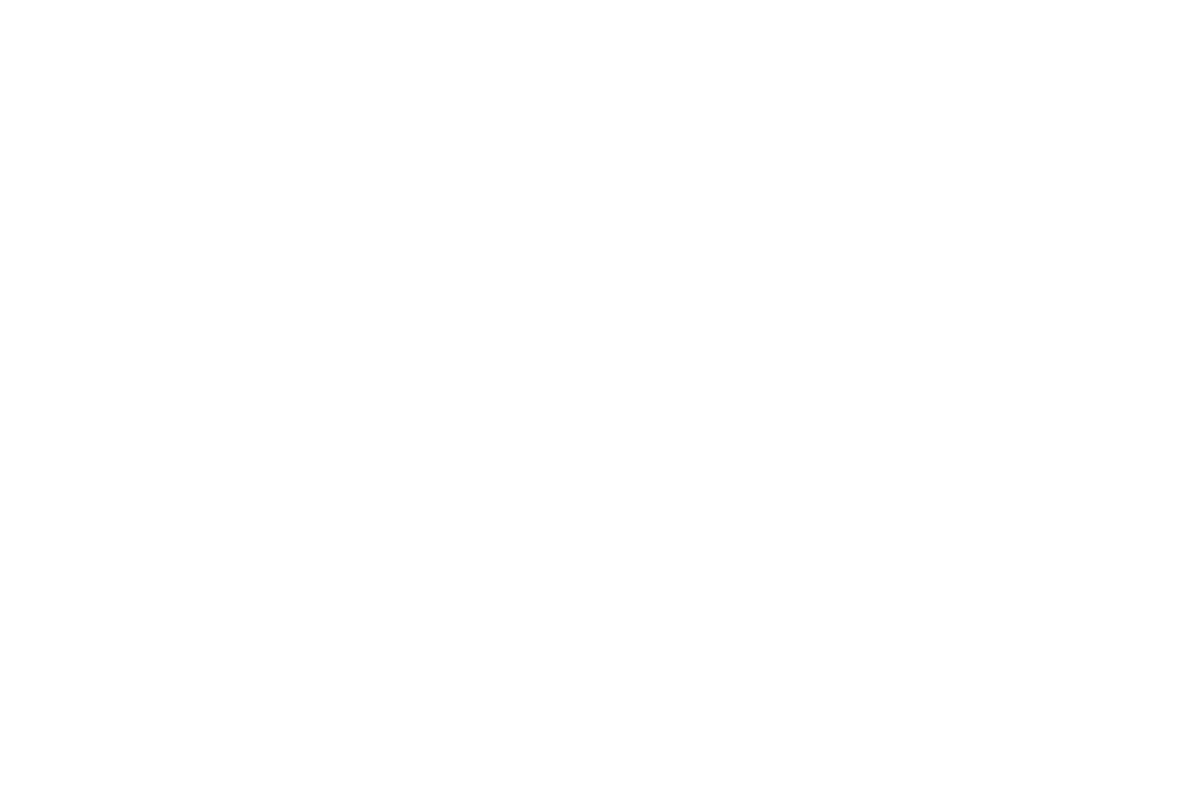

<IPython.core.display.Javascript object>


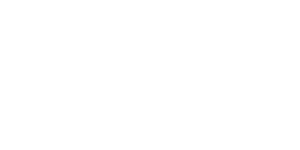

<IPython.core.display.Javascript object>


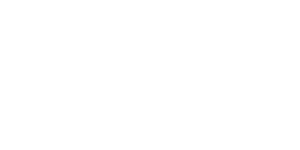

<IPython.core.display.Javascript object>


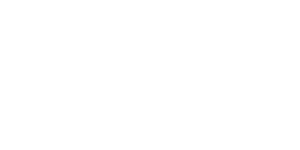

<IPython.core.display.Javascript object>


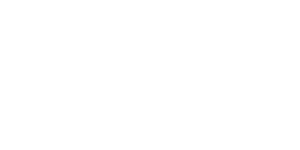

<IPython.core.display.Javascript object>


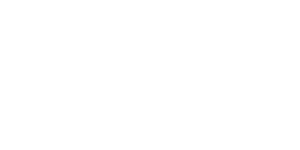

<IPython.core.display.Javascript object>


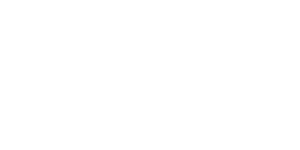

<IPython.core.display.Javascript object>


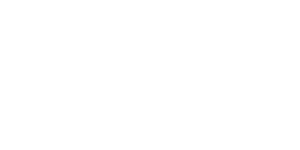

<IPython.core.display.Javascript object>


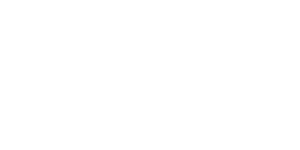

<IPython.core.display.Javascript object>


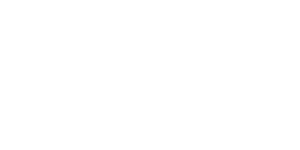

<IPython.core.display.Javascript object>


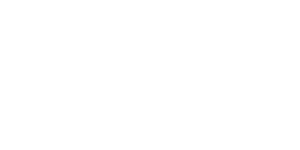

<IPython.core.display.Javascript object>


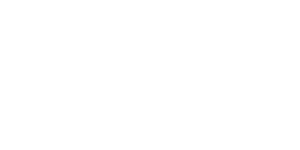

<IPython.core.display.Javascript object>


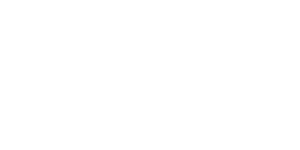

<IPython.core.display.Javascript object>


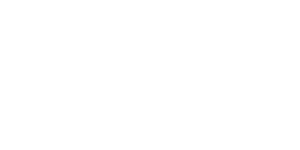

<IPython.core.display.Javascript object>


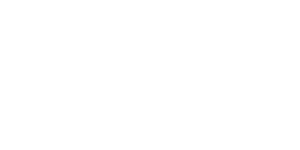

<IPython.core.display.Javascript object>


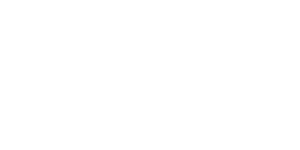

<IPython.core.display.Javascript object>


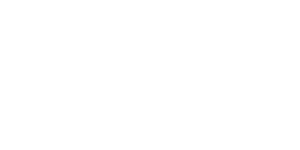

<IPython.core.display.Javascript object>


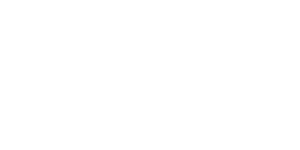

<IPython.core.display.Javascript object>


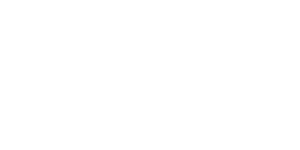

<IPython.core.display.Javascript object>


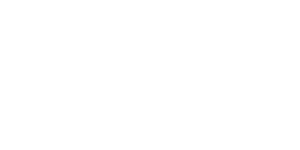

<IPython.core.display.Javascript object>


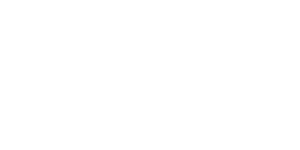

<IPython.core.display.Javascript object>


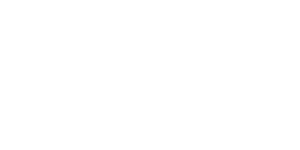

In [85]:
#### for each analysis event - plot one TFR averaged across all epochs for every electrode & save 

for event in analysis_evs: 
    print('Plot TFR for epoch: ',event)
    save_path = f'{tfr_dir}{event}/'
    os.makedirs(save_path,exist_ok = True) #added so you don't have to manually make folders
    
    ev_data = power_epochs[event].copy() # tfr plot data - epochs x num ch x freqs x times 
    times = ev_data.times.copy() # same for all elec
    
    for ch in ev_data.ch_names:
        # single ch tfr 
        plot_data = np.nanmean(np.nanmean(ev_data.copy().pick_channels([ch]).data, axis=0), axis=0) 
        
        fig, ax = plt.subplots(1, 1, figsize=(6, 4),dpi=300)
        
        im = ax.imshow(plot_data,interpolation='Bicubic',
                       aspect='auto', origin='lower', cmap='RdBu_r')
    

        ax.set(xlabel='Time (s)', ylabel='Frequency (Hz)',title=f'{subj_id}_{ch}_{event}_{date}',
               yticks=np.arange(0,len(freqs))[::5], 
               yticklabels=freqs[::5].astype(int), 
               xticks = np.arange(plot_data.shape[1])[::250],
                  xticklabels= times[::250])
        
        fig.colorbar(im, ax=ax)

        plt.savefig(f'{save_path}{subj_id}_{ch}_{event}_{date}.png', dpi=300)
#         bbox_inches=None, pad_inches=0.1,
#         facecolor='auto', edgecolor='auto',backend=None)
        plt.close()

    